# Modélisation - Séries Temporelles avec SARIMAX

In [1]:
import regex as re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
from numba import njit, prange

from concurrent.futures import ThreadPoolExecutor, as_completed
def travail_lourd(x):
    if x == 5:
        raise ValueError("Oups, erreur volontaire pour x=5")
    time.sleep(1)
    return x * x
inputs = list(range(12))
results = []
max_workers = min(4, os.cpu_count() or 1)
with ThreadPoolExecutor(max_workers=max_workers) as exe:
    futures = {exe.submit(travail_lourd, i): i for i in inputs}
    for fut in as_completed(futures):
        i = futures[fut]
        try:
            res = fut.result()
        except Exception as e:
            print(f"Tâche {i} a levé une exception : {e}")
            res = None
        results.append(res)
print("Résultats :", results)
@njit(parallel=True)
def somme_racines(n):
    tmp = np.zeros(n)
    for i in prange(n):
        tmp[i] = np.sqrt(i)
    return np.sum(tmp)

Tâche 7 a levé une exception : name 'time' is not defined
Tâche 4 a levé une exception : name 'time' is not defined
Tâche 6 a levé une exception : name 'time' is not defined
Tâche 3 a levé une exception : name 'time' is not defined
Tâche 1 a levé une exception : name 'time' is not defined
Tâche 8 a levé une exception : name 'time' is not defined
Tâche 5 a levé une exception : Oups, erreur volontaire pour x=5
Tâche 2 a levé une exception : name 'time' is not defined
Tâche 0 a levé une exception : name 'time' is not defined
Tâche 9 a levé une exception : name 'time' is not defined
Tâche 10 a levé une exception : name 'time' is not defined
Tâche 11 a levé une exception : name 'time' is not defined
Résultats : [None, None, None, None, None, None, None, None, None, None, None, None]


In [3]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def somme_racines(n):
    acc = 0.0
    for i in prange(n):
        acc += np.sqrt(i)
    return acc

# utilise tous les threads automatiquement
print(somme_racines(100_000_000))


666666661666.4618


Les données des jeu de test et train sont déjà standardisé et agrégé par mois

In [4]:
## paths
# folder_path_M = '/Users/maximehenon/Documents/GitHub/MAR25_BDS_Compagnon_Immo/'
folder_path_Y = ("C:/Users/charl/OneDrive/Documents/Yasmine/DATASCIENTEST/FEV25-BDS-COMPAGNON")
# folder_path_C = '../data/processed/Sales'
# folder_path_L= '/Users/loick.d/Documents/Datascientest/Github immo/MAR25_BDS_Compagnon_Immo/'


# Load the dataset
# output_file_train = os.path.join(folder_path_M, 'train_periodique_q12.csv')
output_file_train = os.path.join(folder_path_Y, "train_periodique_q12.csv")
# output_file_train = os.path.join(folder_path_C, 'train_periodique_q12.csv')
# output_file_train = os.path.join(folder_path_L, 'train_periodique_q12.csv')


# output_file_test = os.path.join(folder_path_M, 'test_periodique_q12.csv')
output_file_test = os.path.join(folder_path_Y, "test_periodique_q12.csv")
# output_file_test = os.path.join(folder_path_C, 'test_periodique_q12.csv')
# output_file_test = os.path.join(folder_path_L, 'test_periodique_q12.csv')


chunksize = 100000  # Number of rows per chunk
chunks_train = pd.read_csv(
    output_file_train,
    sep=";",
    chunksize=chunksize,
    index_col="date",
    parse_dates=["date"],
    on_bad_lines="skip",
    low_memory=False,
)
chunks_test = pd.read_csv(
    output_file_test,
    sep=";",
    chunksize=chunksize,
    index_col="date",
    parse_dates=["date"],
    on_bad_lines="skip",
    low_memory=False,
)

# Process chunks
train_periodique_q12 = pd.concat(chunk for chunk in chunks_train).sort_values(by="date")
test_periodique_q12 = pd.concat(chunk for chunk in chunks_test).sort_values(by="date")


display(train_periodique_q12.head())
display(test_periodique_q12.head())

Unnamed: 0  taux_rendement_n7  loyer_m2_median_n7     y_geo  \
date                                                                      
2020-01-01           0           0.106784            0.059774  0.080946   
2020-01-01           1           0.849617           -0.591920 -0.259003   
2020-01-01           2           0.976713           -0.745713 -0.019126   
2020-01-01           3          -0.442762            1.249871  0.263153   
2020-02-01           4           0.086868            0.078461  0.079732   

               x_geo     z_geo      dpeL  nb_pieces  IPS_primaire  \
date                                                                
2020-01-01  0.214868 -0.146359  0.068807  -0.107460      0.126866   
2020-01-01 -0.093720 -0.223352  0.285909   0.367624     -0.356773   
2020-01-01  0.042501 -0.063625  0.084782   0.325009     -0.462636   
2020-01-01  0.216575 -0.068559  0.238240  -0.343548      0.597629   
2020-02-01  0.055910 -0.040665  0.116819  -0.156420      0.159006   

            rental_yield_pct      taux  prix_m2_vente  cluster  
date                                                            
2020-01-01         -0.391549 -0.624802       8.164812      0.0  
2020-01-01          0.647271 -0.624802       7.493480      1.0  
2020-01-01          0.863258 -0.624802       7.413835      2.0  
2020-01-01         -1.295596 -0.624802       8.870938      3.0  
2020-02-01         -0.333342 -0.624802       8.174015      0.0

Unnamed: 0  taux_rendement_n7  loyer_m2_median_n7     y_geo  \
date                                                                      
2024-01-01           0          -0.217939            0.030124 -0.006972   
2024-01-01           1          -0.049167           -0.638207 -0.218088   
2024-01-01           2           0.234036           -0.753816 -0.068637   
2024-01-01           3          -0.525277            1.637366  0.066601   
2024-02-01           4          -0.223471            0.058998 -0.007754   

               x_geo     z_geo      dpeL  nb_pieces  IPS_primaire  \
date                                                                
2024-01-01  0.081861 -0.052303 -0.338380  -0.083318      0.194952   
2024-01-01 -0.227386  0.040209 -0.298323   0.268779     -0.318388   
2024-01-01 -0.062609  0.067532 -0.403231   0.292568     -0.360621   
2024-01-01 -0.280205  0.225828 -0.175610  -0.479835      0.878770   
2024-02-01  0.133780 -0.114423 -0.305833  -0.111646      0.200498   

            rental_yield_pct      taux  prix_m2_vente  cluster  
date                                                            
2024-01-01         -0.410489  2.100923       8.290743      0.0  
2024-01-01          0.580675  2.100923       7.804662      1.0  
2024-01-01          0.733374  2.100923       7.676493      2.0  
2024-01-01         -1.259159  2.100923       8.981910      3.0  
2024-02-01         -0.416441  1.987979       8.310139      0.0

In [ ]:
# cluster et labels
Cluster = train_periodique_q12.groupby("cluster","cl").astype("category")


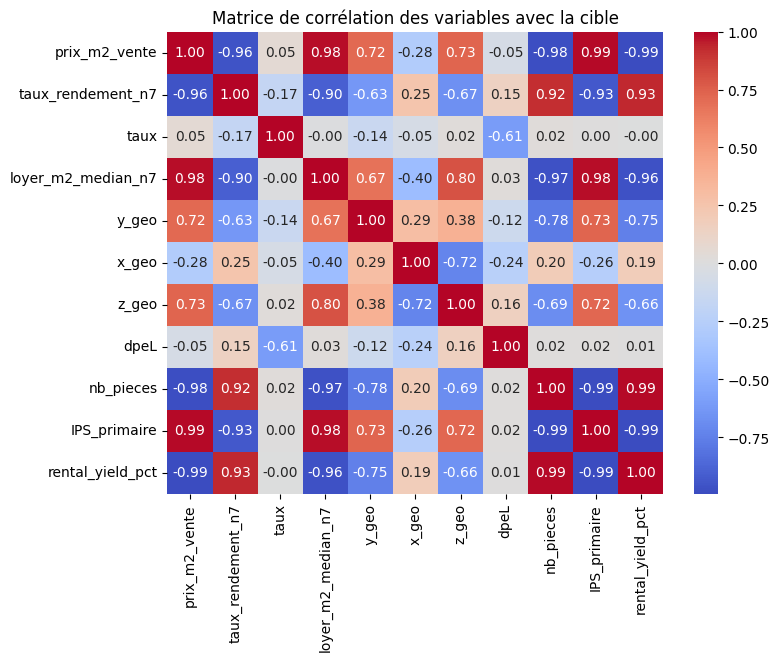

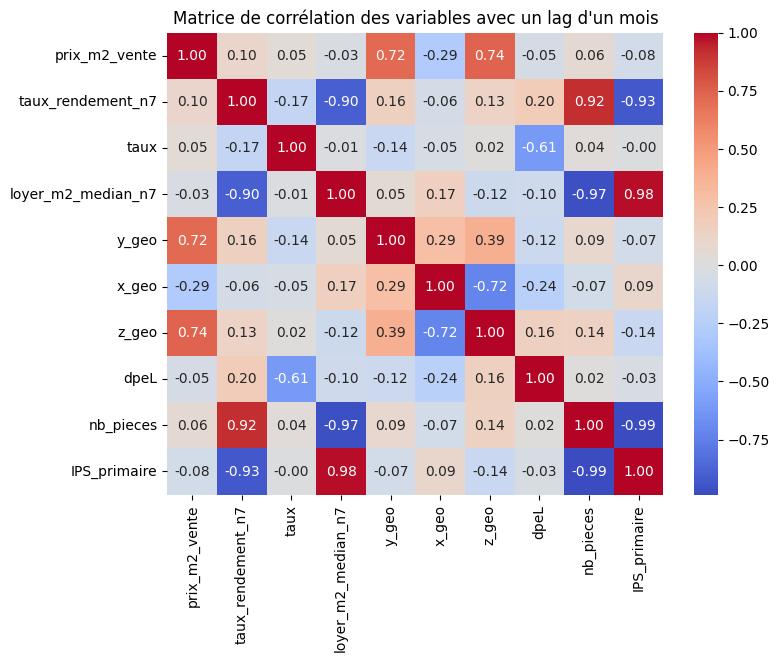

In [5]:
# Les "facteurs exogènes" ici sont en réalité endogène mais elle servent de variables explicatives externes utilisées dans un but prédictif, 
# #connues à l’avance, mais potentiellement endogènes structurellement.
var_targ = ['prix_m2_vente', "taux_rendement_n7", 'taux', "loyer_m2_median_n7","y_geo", "x_geo", "z_geo", "dpeL", "nb_pieces", 'IPS_primaire','rental_yield_pct',]

# Calculer la matrice de corrélation
correlation_matrix = train_periodique_q12[var_targ].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables avec la cible')
plt.show()



'''Les Variables taux_rendement_n7, loyer_m2_median_n7, IPS_primaire et rental_yield_pct sont très corrélées à la variable cible.
Afin d'éviter un Data leak, nous utiliserons ces variables avec un lag de 1 (ici 1 mois)'''
features = ["taux_rendement_n7", 'taux', "loyer_m2_median_n7","y_geo", "x_geo", "z_geo", "dpeL", "nb_pieces", 'IPS_primaire','rental_yield_pct',]

#Définir les variables explicatives (qu’on souhaite décaler d’un mois)
# rental_yield_pct est très corrélé à nb de piece. Variable à exclure
features_lag = ["taux_rendement_n7",  "loyer_m2_median_n7", "nb_pieces", "IPS_primaire"]
features_considere = ['prix_m2_vente', "taux_rendement_n7", 'taux', "loyer_m2_median_n7","y_geo", "x_geo", "z_geo", "dpeL", "nb_pieces", 'IPS_primaire']
# Appliquer le lag 1 à chaque variable (valeur du mois précédent)
for col in features_lag:
    train_periodique_q12[col] = train_periodique_q12[col].shift(1)


# Supprimer les lignes avec valeurs manquantes (au début, à cause du lag)
# On a gardé la même nomenclature pour éviter la complexité au niveau de Streamlit
train_periodique_q12 = train_periodique_q12.dropna(subset= features + ["prix_m2_vente"])

correlation_matrix = train_periodique_q12[features_considere].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation des variables avec un lag d\'un mois')
plt.show()

#### TEST 
for col in features_lag:
    test_periodique_q12[col] = test_periodique_q12[col].shift(1)


# Supprimer les premières lignes avec NaN dues au lag
test_periodique_q12 = test_periodique_q12.dropna(subset=features + ["prix_m2_vente"])

## Modélisation - SARIMAX

### Choisir le modèle qui donne les résidus les plus stationnaires


=== Traitement du cluster 0.0 ===


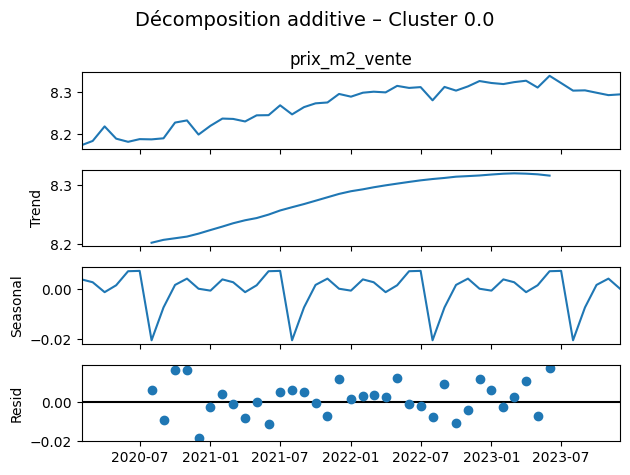

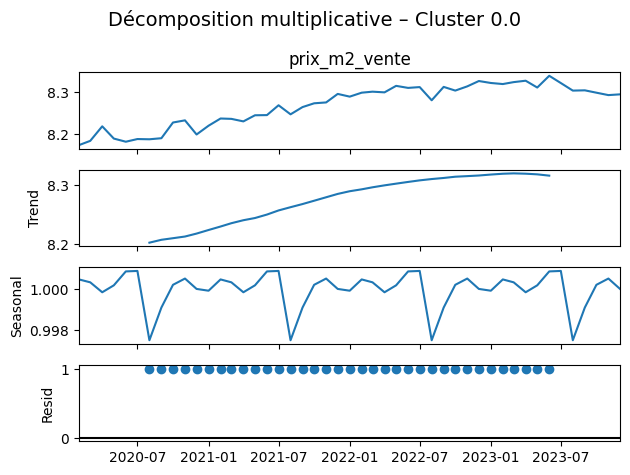


=== Traitement du cluster 1.0 ===


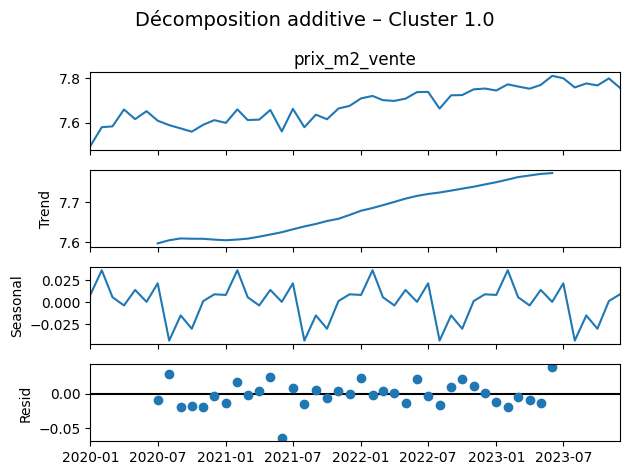

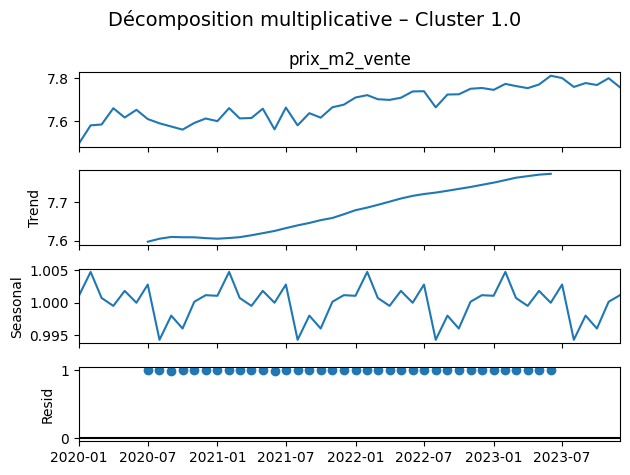


=== Traitement du cluster 2.0 ===


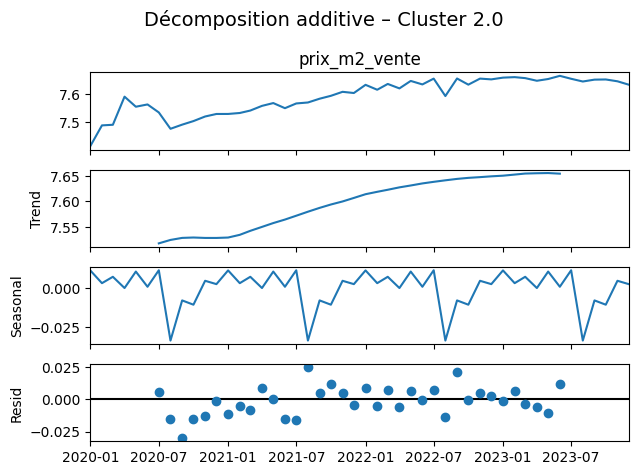

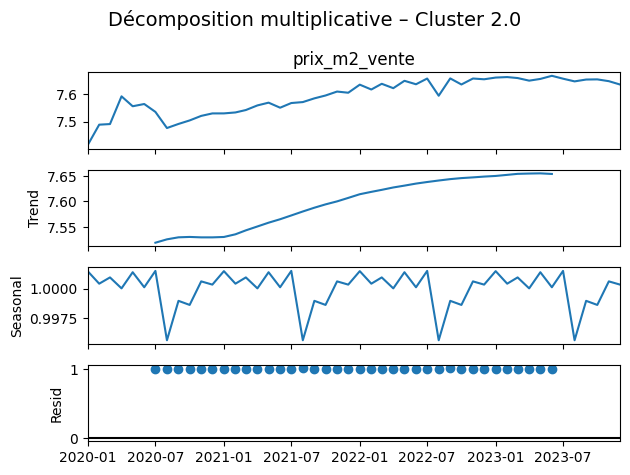


=== Traitement du cluster 3.0 ===


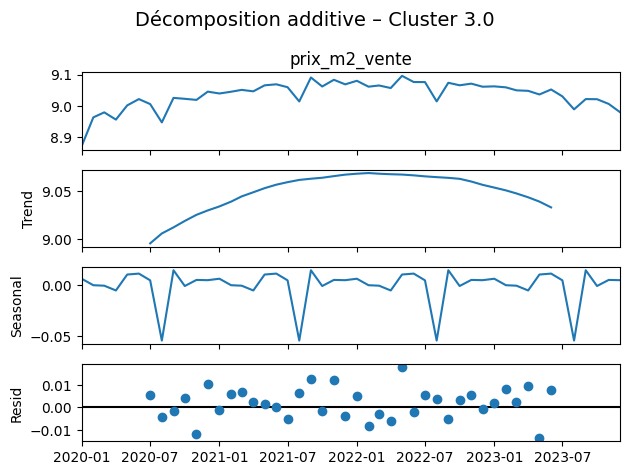

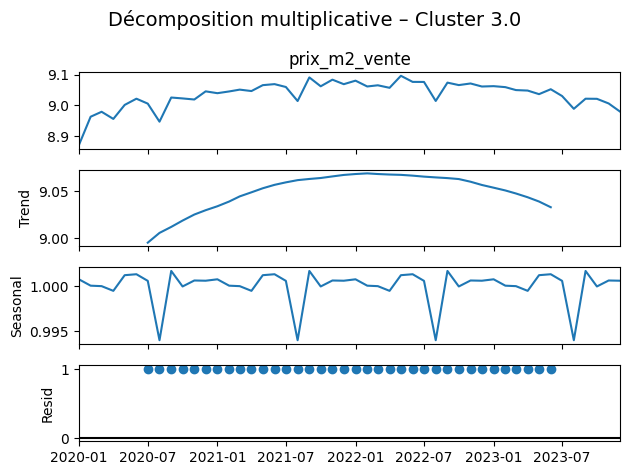

In [6]:
for cluster in sorted(train_periodique_q12["cluster"].dropna().unique()):
    print(f"\n=== Traitement du cluster {cluster} ===")

    # Extraire la série de prix par cluster
    df_cluster = train_periodique_q12[train_periodique_q12["cluster"] == cluster]
    y = df_cluster["prix_m2_vente"]
    y.index = pd.DatetimeIndex(y.index).to_period("M").to_timestamp()

    # Décomposition additive
    data_add = seasonal_decompose(y, model="additive", period=12)
    # plt.figure(figsize=(6, 6))
    data_add.plot()
    plt.suptitle(f"Décomposition additive – Cluster {cluster}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Décomposition multiplicative
    data_mult = seasonal_decompose(y, model="multiplicative", period=12)
    # plt.figure(figsize=(6, 6))
    data_mult.plot()
    plt.suptitle(f"Décomposition multiplicative – Cluster {cluster}", fontsize=14)
    plt.tight_layout()
    plt.show();

La série corrigée de ses variations saisonnières



=== Correction saisonnière – Cluster 0.0 ===


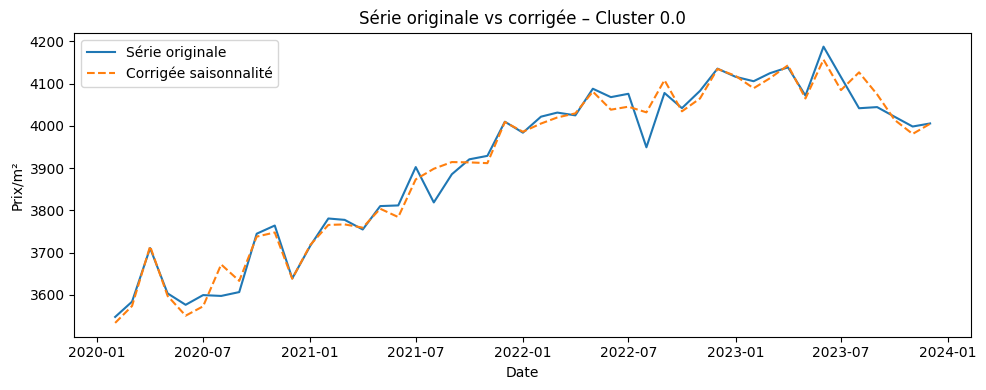


=== Correction saisonnière – Cluster 1.0 ===


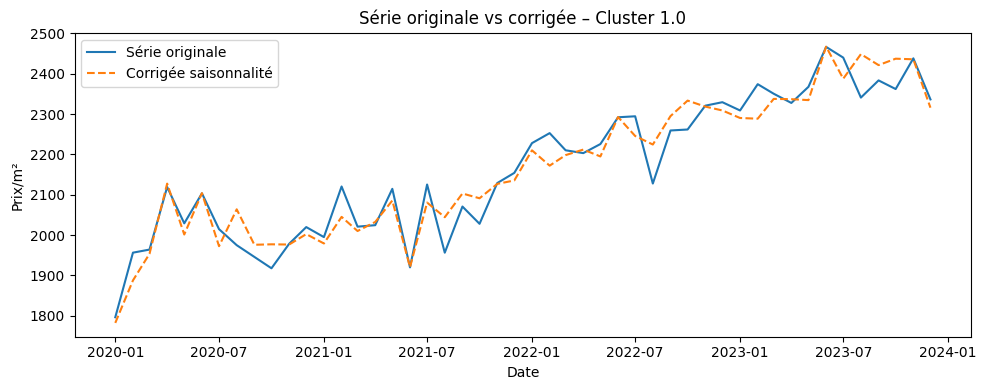


=== Correction saisonnière – Cluster 2.0 ===


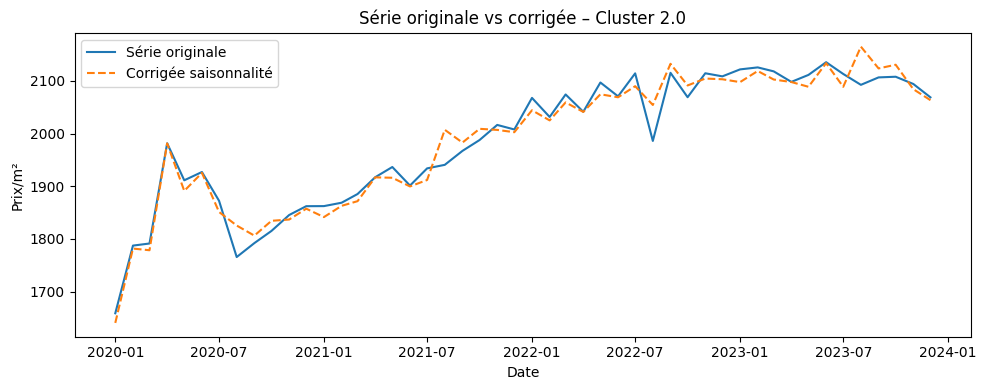


=== Correction saisonnière – Cluster 3.0 ===


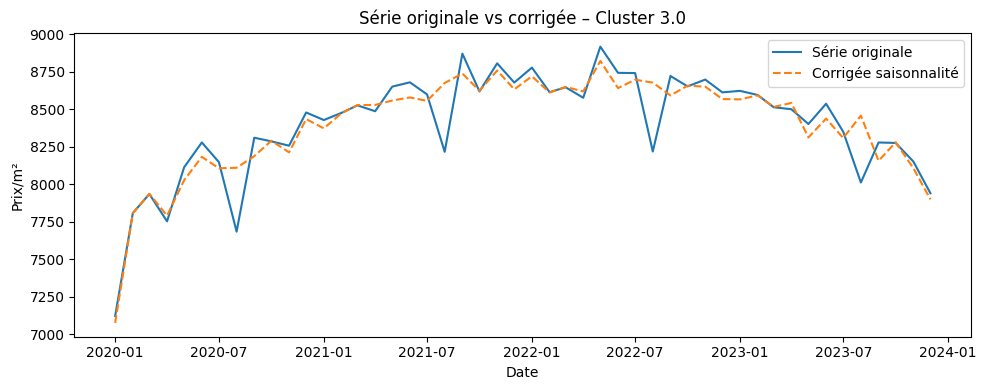

In [7]:
for cluster in sorted(train_periodique_q12["cluster"].dropna().unique()):
    print(f"\n=== Correction saisonnière – Cluster {cluster} ===")

    # Filtrer les données du cluster
    df_cluster = train_periodique_q12[train_periodique_q12["cluster"] == cluster]

    # Extraire la série
    y = df_cluster["prix_m2_vente"]
    y.index = pd.DatetimeIndex(df_cluster.index).to_period("M").to_timestamp()

    # Décomposition multiplicative

    data_mult = seasonal_decompose(y, model="multiplicative", period=12)

    # Correction : log(y) - composante saisonnière => puis exp()
    cvs = y / data_mult.seasonal
    y_corrige = np.exp(cvs)

    # Affichage
    plt.figure(figsize=(10, 4))
    plt.plot(np.exp(y), label="Série originale")
    plt.plot(y_corrige, label="Corrigée saisonnalité", linestyle="--")
    plt.title(f"Série originale vs corrigée – Cluster {cluster}")
    plt.xlabel("Date")
    plt.ylabel("Prix/m²")
    plt.legend()
    plt.tight_layout()
    plt.show()

Vérification de la stationnarité pour utiliser le modèle SARIMAX



=== Autocorrélation plot – Cluster 0.0 ===


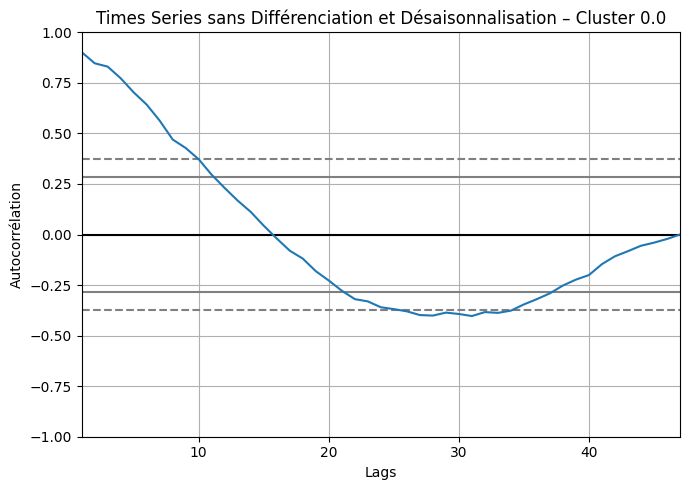


=== Autocorrélation plot – Cluster 1.0 ===


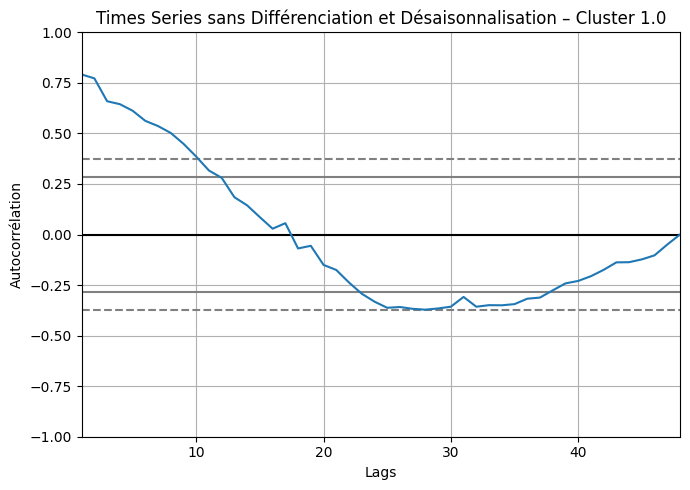


=== Autocorrélation plot – Cluster 2.0 ===


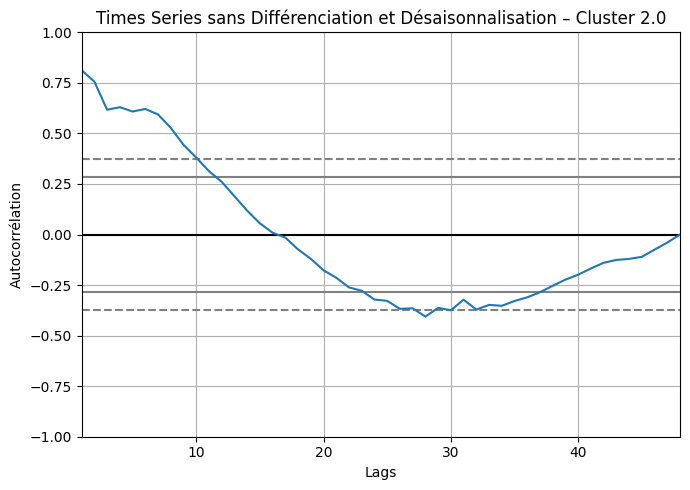


=== Autocorrélation plot – Cluster 3.0 ===


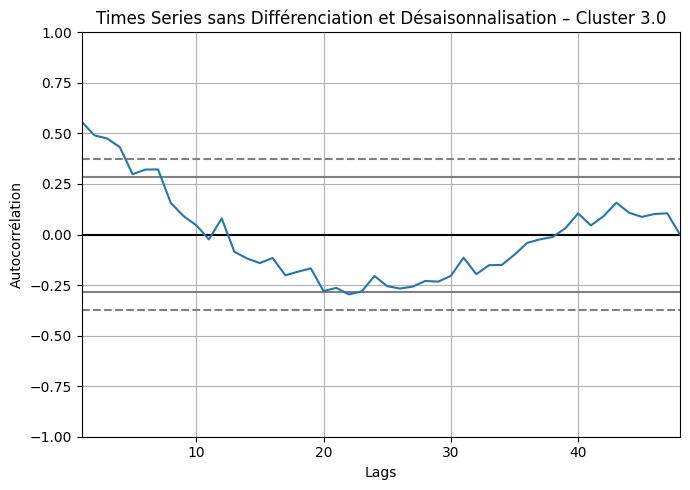

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

for cluster in sorted(train_periodique_q12["cluster"].dropna().unique()):
    print(f"\n=== Autocorrélation plot – Cluster {cluster} ===")

    y = train_periodique_q12[train_periodique_q12["cluster"] == cluster][
        "prix_m2_vente"
    ]
    y.index = (
        pd.DatetimeIndex(y.index).to_period("M").to_timestamp()
    )  # S'assurer que l'index est temporel

    plt.figure(figsize=(7, 5))
    pd.plotting.autocorrelation_plot(y)
    plt.title(
        f"Times Series sans Différenciation et Désaisonnalisation – Cluster {cluster}"
    )
    plt.xlabel("Lags")
    plt.ylabel("Autocorrélation")
    plt.tight_layout()
    plt.show()

### Différenciation



=== Différenciation - Cluster 0 ===



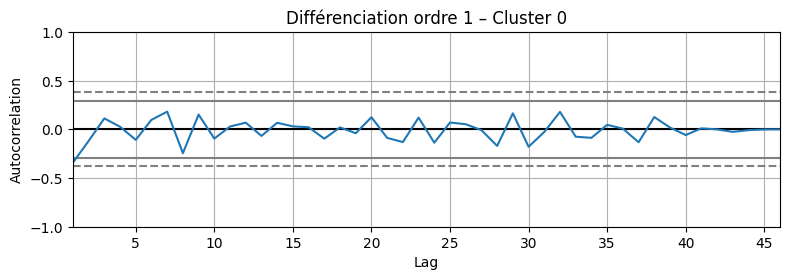



=== Différenciation - Cluster 1 ===



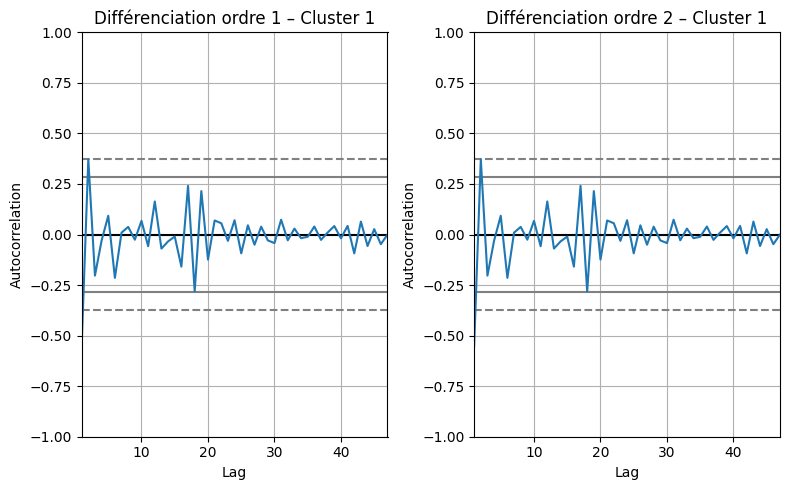



=== Différenciation - Cluster 2 ===



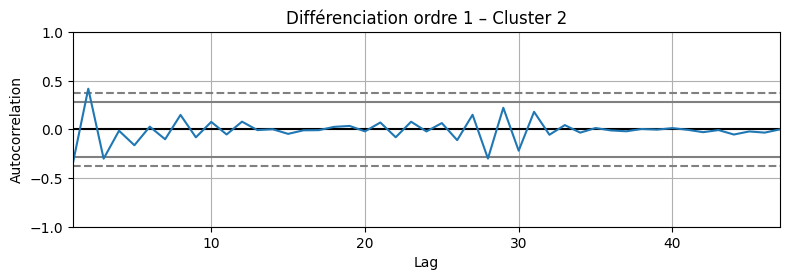



=== Différenciation - Cluster 3 ===



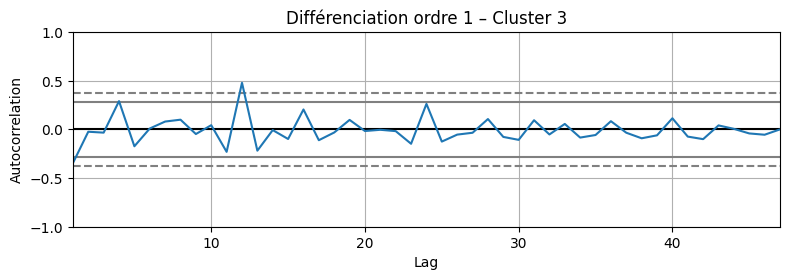

In [9]:
print("\n==============================")
print("\n=== Différenciation - Cluster 0 ===")
print("\n==============================")
# Extraire la série de prix par cluster

clusters_st_0 = pd.DataFrame()
df_cluster_0 = train_periodique_q12[train_periodique_q12["cluster"] == 0]
y = df_cluster_0["prix_m2_vente"]
y.index = pd.DatetimeIndex(y.index).to_period("M").to_timestamp()
y = np.log(y)
y_diff_order_1 = y.diff().dropna()
# y_diff_order_2 = y_diff_order_1.diff().dropna()


# Convertir la Serie en Dataframe
y_diff_order_1 = y_diff_order_1.to_frame(name="prix_m2_vente")
# y_diff_order_2 = y_diff_order_2.to_frame(name='prix_m2_vente')
# Renommer la colonne
y_diff_order_1.rename(columns={"prix_m2_vente": "diff_order_1"}, inplace=True)
# y_diff_order_2.rename(columns={'prix_m2_vente': 'diff_order_2'}, inplace=True)
# Afficher la série
y_diff_order_1.index = (
    pd.DatetimeIndex(y_diff_order_1.index).to_period("M").to_timestamp()
)
# y_diff_order_2.index = pd.DatetimeIndex(y_diff_order_2.index).to_period('M').to_timestamp()


# Concaténation
clusters_st_0 = pd.concat([clusters_st_0, y_diff_order_1], axis=0)
clusters_st_0["cluster"] = 0

# Tracés
plt.figure(figsize=(8, 5))
plt.subplot(211)
pd.plotting.autocorrelation_plot(y_diff_order_1)
plt.title("Différenciation ordre 1 – Cluster 0")
plt.grid(True)

# plt.subplot(212)
# pd.plotting.autocorrelation_plot(y_diff_order_1)
# plt.title(f"Différenciation ordre 2 – Cluster {cluster}")
# plt.grid(True)

plt.tight_layout()
plt.show()


print("\n==============================")
print("\n=== Différenciation - Cluster 1 ===")
print("\n==============================")
# Extraire la série de prix par cluster

clusters_st_1 = pd.DataFrame()
df_cluster_1 = train_periodique_q12[train_periodique_q12["cluster"] == 1]
y = df_cluster_1["prix_m2_vente"]
y.index = pd.DatetimeIndex(y.index).to_period("M").to_timestamp()
y = np.log(y)


y_diff_order_1 = y.diff().dropna()
y_diff_order_2 = y_diff_order_1.diff().dropna()


# Convertir la Serie en Dataframe
y_diff_order_1 = y_diff_order_1.to_frame(name="prix_m2_vente")
y_diff_order_2 = y_diff_order_2.to_frame(name="prix_m2_vente")

# Renommer la colonne
y_diff_order_1.rename(columns={"prix_m2_vente": "diff_order_1"}, inplace=True)
y_diff_order_2.rename(columns={"prix_m2_vente": "diff_order_2"}, inplace=True)
# Afficher la série
y_diff_order_1.index = (
    pd.DatetimeIndex(y_diff_order_1.index).to_period("M").to_timestamp()
)
y_diff_order_2.index = (
    pd.DatetimeIndex(y_diff_order_2.index).to_period("M").to_timestamp()
)


# Concaténation
clusters_st_1 = pd.concat([y_diff_order_1, y_diff_order_2], axis=1)
clusters_st_1["cluster"] = 1

# Tracés
plt.figure(figsize=(8, 5))
plt.subplot(121)
pd.plotting.autocorrelation_plot(y_diff_order_1)
plt.title("Différenciation ordre 1 – Cluster 1")
plt.grid(True)

plt.subplot(122)
pd.plotting.autocorrelation_plot(y_diff_order_1)
plt.title(f"Différenciation ordre 2 – Cluster 1")
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n==============================")
print("\n=== Différenciation - Cluster 2 ===")
print("\n==============================")

# Extraire la série de prix par cluster
clusters_st_2 = pd.DataFrame()
df_cluster_2 = train_periodique_q12[train_periodique_q12["cluster"] == 2]


y = df_cluster_2["prix_m2_vente"]
y.index = pd.DatetimeIndex(y.index).to_period("M").to_timestamp()
y = np.log(y)
y_diff_order_1 = y.diff().dropna()
# y_diff_order_2 = y_diff_order_1.diff().dropna()


# Convertir la Serie en Dataframe
y_diff_order_1 = y_diff_order_1.to_frame(name="prix_m2_vente")
# y_diff_order_2 = y_diff_order_2.to_frame(name='prix_m2_vente')
# Renommer la colonne
y_diff_order_1.rename(columns={"prix_m2_vente": "diff_order_1"}, inplace=True)
# y_diff_order_2.rename(columns={'prix_m2_vente': 'diff_order_2'}, inplace=True)
# Afficher la série
y_diff_order_1.index = (
    pd.DatetimeIndex(y_diff_order_1.index).to_period("M").to_timestamp()
)
# y_diff_order_2.index = pd.DatetimeIndex(y_diff_order_2.index).to_period('M').to_timestamp()


# Concaténation
clusters_st_2 = pd.concat([clusters_st_2, y_diff_order_1], axis=0)
clusters_st_2["cluster"] = 2

# Tracés
plt.figure(figsize=(8, 5))
plt.subplot(211)
pd.plotting.autocorrelation_plot(y_diff_order_1)
plt.title("Différenciation ordre 1 – Cluster 2")
plt.grid(True)

# plt.subplot(212)
# pd.plotting.autocorrelation_plot(y_diff_order_1)
# plt.title(f"Différenciation ordre 2 – Cluster {cluster}")
# plt.grid(True)

plt.tight_layout()
plt.show()


print("\n==============================")
print("\n=== Différenciation - Cluster 3 ===")
print("\n==============================")
# Extraire la série de prix par cluster
clusters_st_3 = pd.DataFrame()
df_cluster_3 = train_periodique_q12[train_periodique_q12["cluster"] == 3]
y = df_cluster_3["prix_m2_vente"]
y.index = pd.DatetimeIndex(y.index).to_period("M").to_timestamp()

y_diff_order_1 = y.diff().dropna()
# y_diff_order_2 = y_diff_order_1.diff().dropna()


# Convertir la Serie en Dataframe
y_diff_order_1 = y_diff_order_1.to_frame(name="prix_m2_vente")
# y_diff_order_2 = y_diff_order_2.to_frame(name='prix_m2_vente')
# Renommer la colonne
y_diff_order_1.rename(columns={"prix_m2_vente": "diff_order_1"}, inplace=True)
# y_diff_order_2.rename(columns={'prix_m2_vente': 'diff_order_2'}, inplace=True)
# Afficher la série
y_diff_order_1.index = (
    pd.DatetimeIndex(y_diff_order_1.index).to_period("M").to_timestamp()
)
# y_diff_order_2.index = pd.DatetimeIndex(y_diff_order_2.index).to_period('M').to_timestamp()


# Concaténation
clusters_st_3 = pd.concat([clusters_st_3, y_diff_order_1], axis=0)
clusters_st_3["cluster"] = 3

# display(clusters_st_3.head())

# Tracés
plt.figure(figsize=(8, 5))
plt.subplot(211)
pd.plotting.autocorrelation_plot(y_diff_order_1)
plt.title("Différenciation ordre 1 – Cluster 3")
plt.grid(True)

# plt.subplot(212)
# pd.plotting.autocorrelation_plot(y_diff_order_1)
# plt.title(f"Différenciation ordre 2 – Cluster {cluster}")
# plt.grid(True)

plt.tight_layout()
plt.show()

### Test AD Fuller

In [10]:
# Fonction pour effectuer le test ADF
def test_stationarity(timeseries, window=12):
    # Calculer la moyenne mobile et l'écart type mobile
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Tracer la série temporelle, la moyenne mobile et l'écart type mobile
    plt.figure(figsize=(8, 6))
    plt.plot(timeseries, color="blue", label="Série originale")
    plt.plot(rolmean, color="red", label="Moyenne mobile")
    plt.plot(rolstd, color="black", label="Écart type mobile")
    plt.legend(loc="best")
    plt.title("Moyenne mobile et écart type mobile")
    plt.grid(True)
    plt.show()

    # Effectuer le test ADF
    result = adfuller(timeseries.dropna())
    print("Résultats du test ADF:")
    print("Statistique ADF:", result[0])
    print("p-value:", result[1])
    print("Valeurs critiques:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    # Interprétation des résultats
    if result[1] < 0.05:
        print("La série est stationnaire (p-value < 0.05)")
        return True
    else:
        print("La série n'est pas stationnaire (p-value >= 0.05)")
        return False



=== Différenciation - Cluster 0 ===



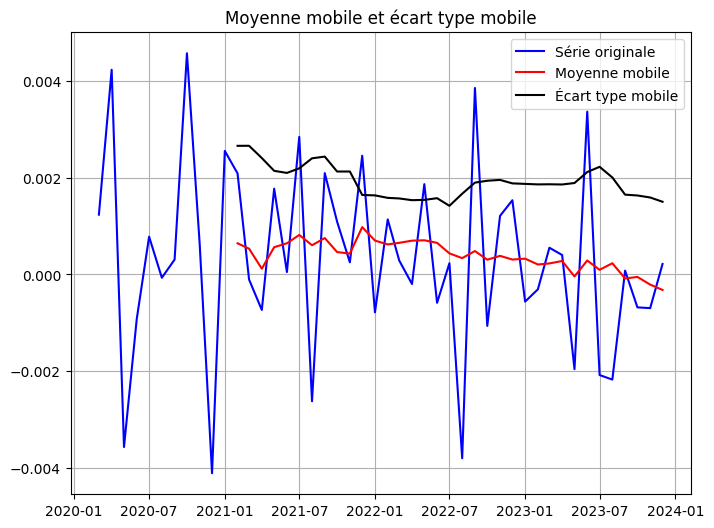

Résultats du test ADF:
Statistique ADF: -9.391788421343287
p-value: 6.531385645337776e-16
Valeurs critiques:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937
La série est stationnaire (p-value < 0.05)


=== Différenciation - Cluster 1 ===



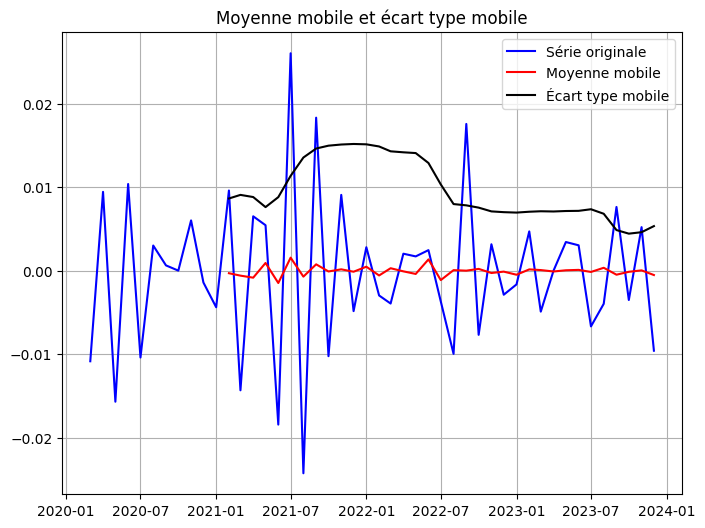

Résultats du test ADF:
Statistique ADF: -4.168894997696278
p-value: 0.0007435009989952405
Valeurs critiques:
	1%: -3.6327426647230316
	5%: -2.9485102040816327
	10%: -2.6130173469387756
La série est stationnaire (p-value < 0.05)


=== Différenciation - Cluster 2 ===



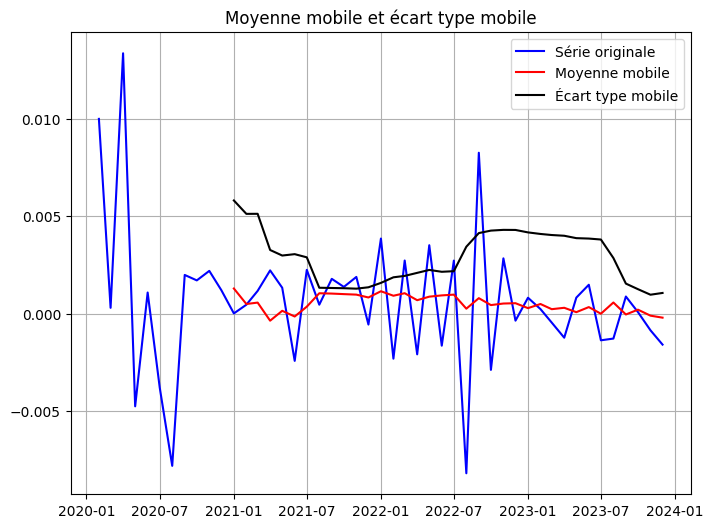

Résultats du test ADF:
Statistique ADF: -10.403339423558062
p-value: 1.8844194106310607e-18
Valeurs critiques:
	1%: -3.5812576580093696
	5%: -2.9267849124681518
	10%: -2.6015409829867675
La série est stationnaire (p-value < 0.05)


=== Différenciation - Cluster 3 ===



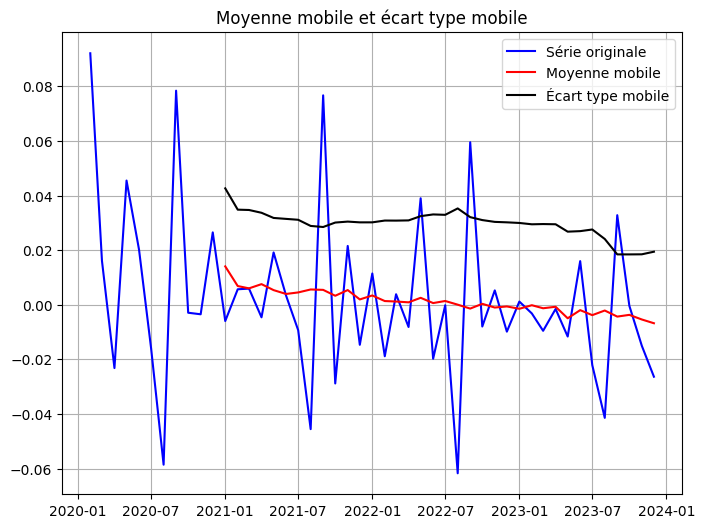

Résultats du test ADF:
Statistique ADF: -0.6043216581120423
p-value: 0.8700025159576101
Valeurs critiques:
	1%: -3.626651907578875
	5%: -2.9459512825788754
	10%: -2.6116707716049383
La série n'est pas stationnaire (p-value >= 0.05)
Warning ! - Cluster #3.0 La série n'est pas stationnaire (p-value >= 0.05)



In [11]:
# Effectuer le test ADF sur les time series
cluster_to_fix = []
print("\n==============================")
print("\n=== Différenciation - Cluster 0 ===")
print("\n==============================")

# Extraire la série de prix par cluster
cluster_data = clusters_st_0[clusters_st_0["cluster"] == 0]
result = test_stationarity(cluster_data["diff_order_1"], window=12)

if not result:
    cluster_to_fix.append(cluster)
    print(
        f"Warning ! - Cluster #{cluster} La série n'est pas stationnaire (p-value >= 0.05)\n"
    )

print("\n==============================")
print("\n=== Différenciation - Cluster 1 ===")
print("\n==============================")

# Extraire la série de prix par cluster
cluster_data = clusters_st_1[clusters_st_1["cluster"] == 1]
result = test_stationarity(cluster_data["diff_order_2"], window=12)

if not result:
    cluster_to_fix.append(cluster)
    print(
        f"Warning ! - Cluster #{cluster} La série n'est pas stationnaire (p-value >= 0.05)\n"
    )

print("\n==============================")
print("\n=== Différenciation - Cluster 2 ===")
print("\n==============================")

# Extraire la série de prix par cluster
cluster_data = clusters_st_2[clusters_st_2["cluster"] == 2]
result = test_stationarity(cluster_data["diff_order_1"], window=12)

if not result:
    cluster_to_fix.append(cluster)
    print(
        f"Warning ! - Cluster #{cluster} La série n'est pas stationnaire (p-value >= 0.05)\n"
    )

print("\n==============================")
print("\n=== Différenciation - Cluster 3 ===")
print("\n==============================")

# Extraire la série de prix par cluster
cluster_data = clusters_st_3[clusters_st_3["cluster"] == 3]
result = test_stationarity(cluster_data["diff_order_1"], window=12)

if not result:
    cluster_to_fix.append(cluster)
    print(
        f"Warning ! - Cluster #{cluster} La série n'est pas stationnaire (p-value >= 0.05)\n"
    )

### ACF et PACF



=== Différenciation - Cluster 0 ===



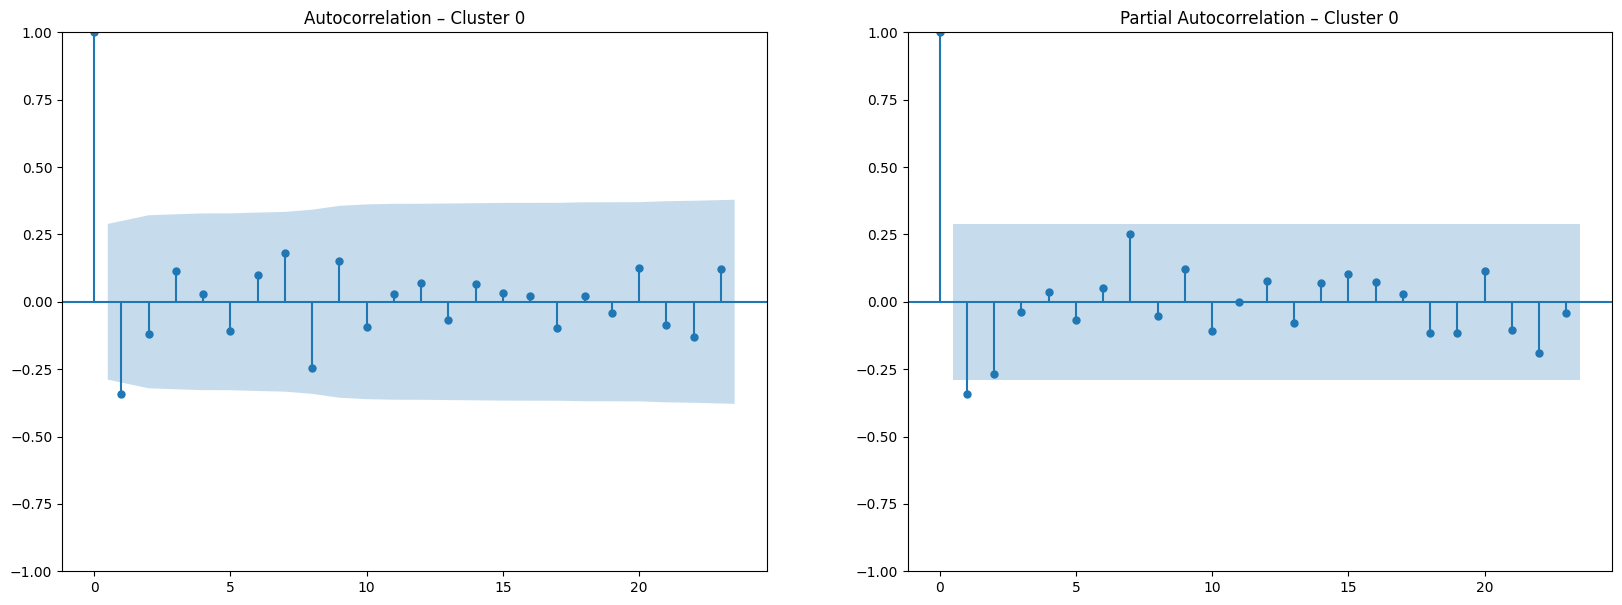



=== Différenciation - Cluster 1 ===



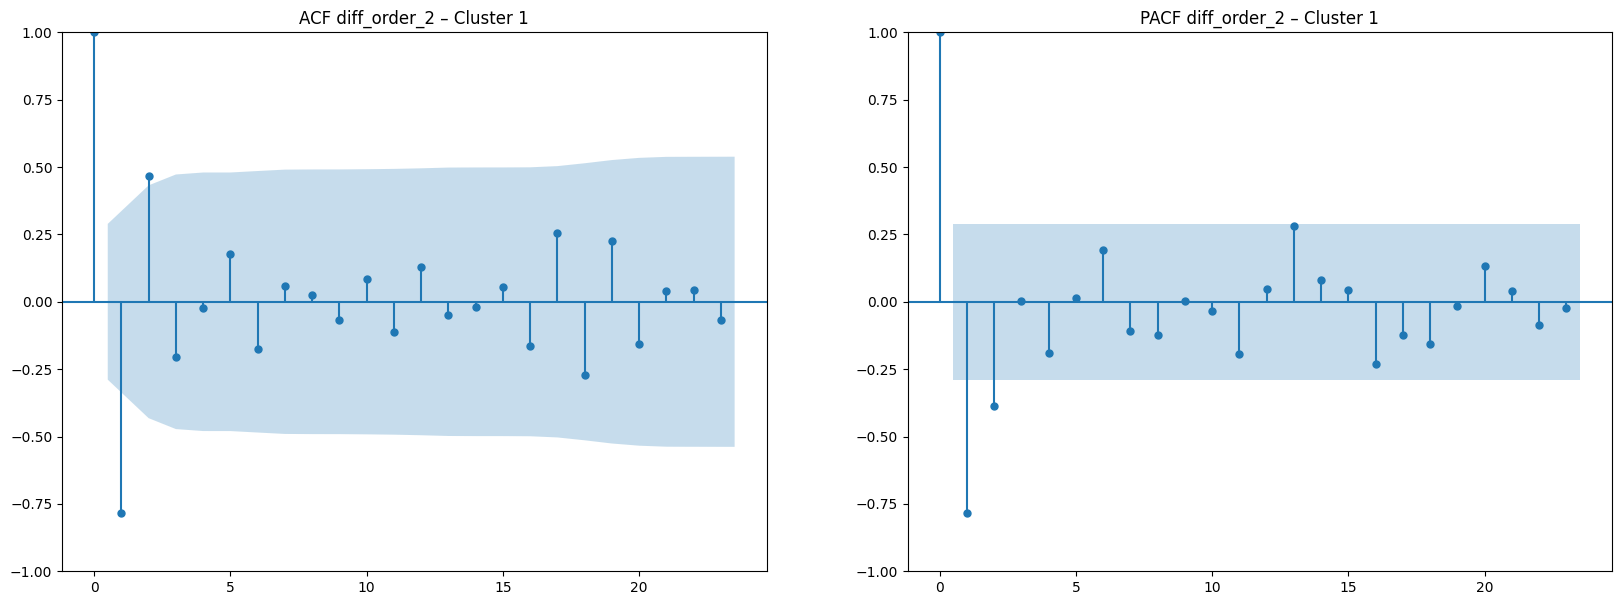



=== Différenciation - Cluster 2 ===



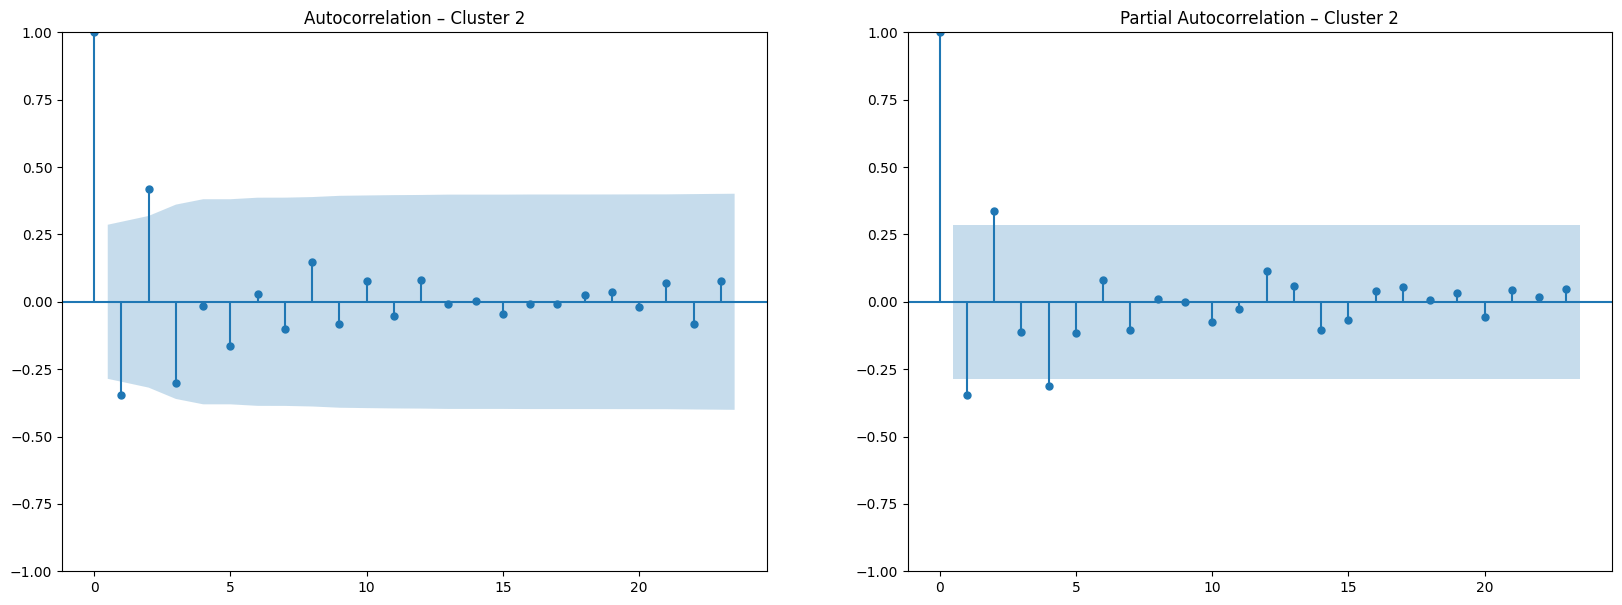



=== Différenciation - Cluster 3 ===



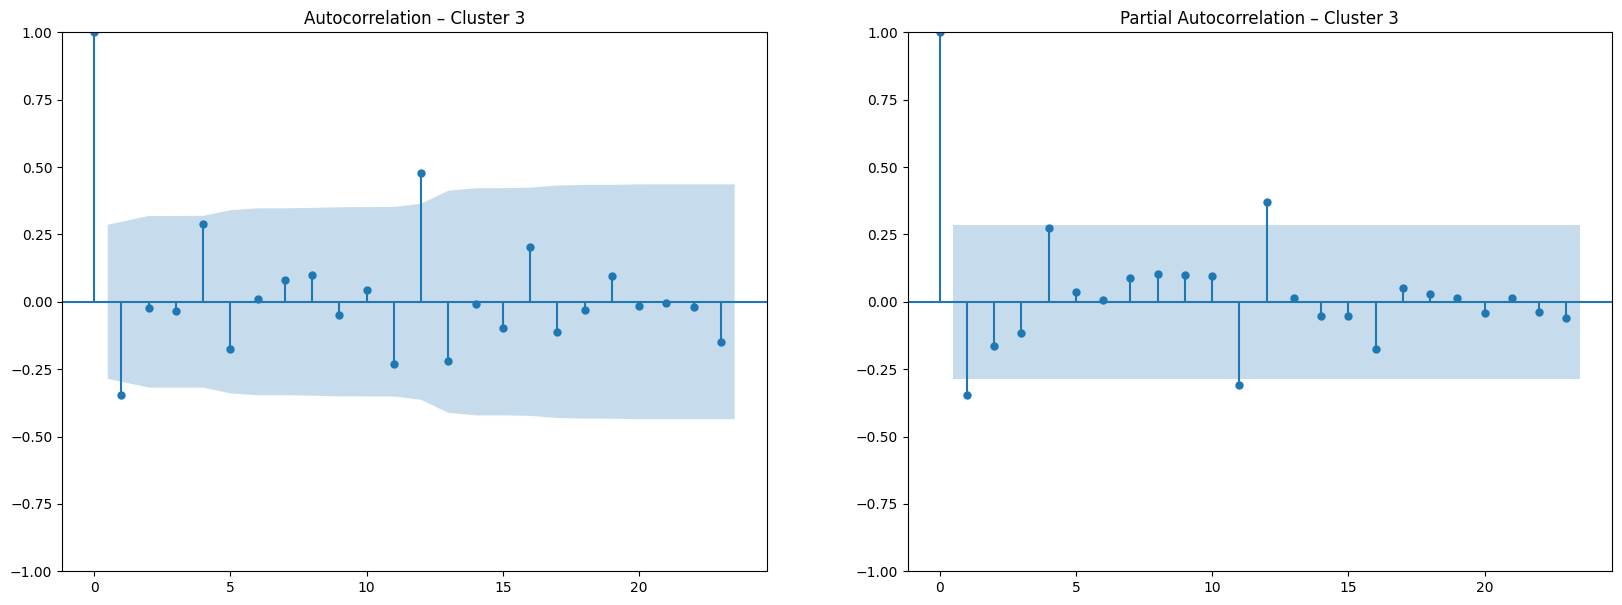

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

print("\n==============================")
print("\n=== Différenciation - Cluster 0 ===")
print("\n==============================")
cluster = 0
# Sélectionnez les données pour ce cluster
cluster_data = clusters_st_0[clusters_st_0["cluster"] == cluster]

# Vérifiez qu'il y a assez de points
if cluster_data.empty:
    print(f"Cluster {cluster} has no data. Skipping...")
else:
    max_lags = len(cluster_data) // 2
    if max_lags <= 0:
        print(f"Cluster {cluster} has insufficient data for ACF/PACF. Skipping...")
    else:
        # Tracé
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
        plot_acf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax1,
            title=f"Autocorrelation – Cluster {cluster}",
        )
        plot_pacf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax2,
            title=f"Partial Autocorrelation – Cluster {cluster}",
        )
        plt.show()


print("\n==============================")
print("\n=== Différenciation - Cluster 1 ===")
print("\n==============================")

series = clusters_st_1["diff_order_2"].dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_acf(series, lags=len(series) // 2, ax=ax1, title="ACF diff_order_2 – Cluster 1")
plot_pacf(series, lags=len(series) // 2, ax=ax2, title="PACF diff_order_2 – Cluster 1")
plt.show()


print("\n==============================")
print("\n=== Différenciation - Cluster 2 ===")
print("\n==============================")
cluster = 2
# Sélectionnez les données pour ce cluster
cluster_data = clusters_st_2[clusters_st_2["cluster"] == cluster]
# Vérifiez qu'il y a assez de points
if cluster_data.empty:
    print(f"Cluster {cluster} has no data. Skipping...")
else:
    max_lags = len(cluster_data) // 2
    if max_lags <= 0:
        print(f"Cluster {cluster} has insufficient data for ACF/PACF. Skipping...")
    else:
        # Tracé
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
        plot_acf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax1,
            title=f"Autocorrelation – Cluster {cluster}",
        )
        plot_pacf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax2,
            title=f"Partial Autocorrelation – Cluster {cluster}",
        )
        plt.show()

print("\n==============================")
print("\n=== Différenciation - Cluster 3 ===")
print("\n==============================")
cluster = 3
# Sélectionnez les données pour ce cluster
cluster_data = clusters_st_3[clusters_st_3["cluster"] == cluster]
# Vérifiez qu'il y a assez de points
if cluster_data.empty:
    print(f"Cluster {cluster} has no data. Skipping...")
else:
    max_lags = len(cluster_data) // 2
    if max_lags <= 0:
        print(f"Cluster {cluster} has insufficient data for ACF/PACF. Skipping...")
    else:
        # Tracé
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
        plot_acf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax1,
            title=f"Autocorrelation – Cluster {cluster}",
        )
        plot_pacf(
            cluster_data["diff_order_1"],
            lags=max_lags,
            ax=ax2,
            title=f"Partial Autocorrelation – Cluster {cluster}",
        )
        plt.show()

| Cluster # | p | q | P | Q | d | D | S |
|---------|---|---|---|---|---|---|---|
| 0       | 1  | 2 | 0 | 0 | 1 | 0 | 0 |
| 1       | 1 | 1 | 0 | 0 | 0 | 0| 12 | 
| 2       | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 
| 3       | 2 | 1 | 0 | 0 | 1 | 0 | 12 | 

CLUSTER 0 : La PACF présente deux pics significatifs hors de l’intervalle de confiance (aux lags 1 et 2), puis retombe dans le bruit : c’est le signe typique d’un AR(2). ET pas de coupure nette à     
                                     q=1mais plutôt un amortissement, ce qui milite pour q = 0
CLUSTER 1 : Saisonalité suggéré par les pic en lag 1 puis 12. PACF: Lag 1 sort nettement de la bande de confiance (≈ –0.45). ACF: coupure nette en lag 1 > q=1
CLUSTER 2: 
CLUSTER 3: PACF 2 lags significatifs p=2 ACF q=1, n petit rebond à 12 dans la PACF s=12, ACF est un pic net et non un amortissement lent aux lags multiples, D = 0 et P = 0

### SARIMAX

#### Grid Search (avec parallelisation sur tous les coeurs)


=== Traitement du cluster 0 ===
Parallélisation sur 12 cœurs pour 18360 modèles…


Grid Search: 100%|██████████| 18360/18360 [26:59<00:00, 11.34it/s]


Meilleure combo exogènes : ('taux_rendement_n7', 'y_geo', 'dpeL', 'IPS_primaire')
Meilleur ordre (p,d,q)   : (0, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -260.5019097254141


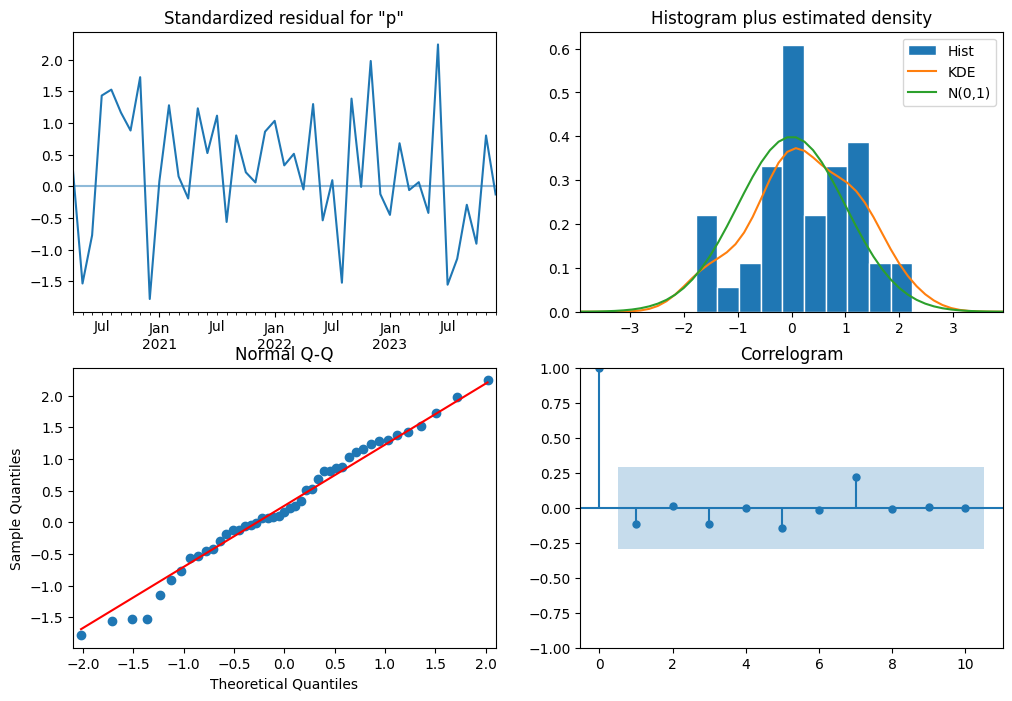

Modèle sauvegardé sous 'best_sarimax_cluster0_parallel.joblib'
Meilleure combo exogènes : ('taux_rendement_n7', 'y_geo', 'dpeL', 'IPS_primaire')
Meilleur ordre (p,d,q)   : (0, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -260.5019097254141
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   47
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 135.251
Date:                Mon, 02 Jun 2025   AIC                           -260.502
Time:                        17:31:49   BIC                           -251.469
Sample:                    02-01-2020   HQIC                          -257.134
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------

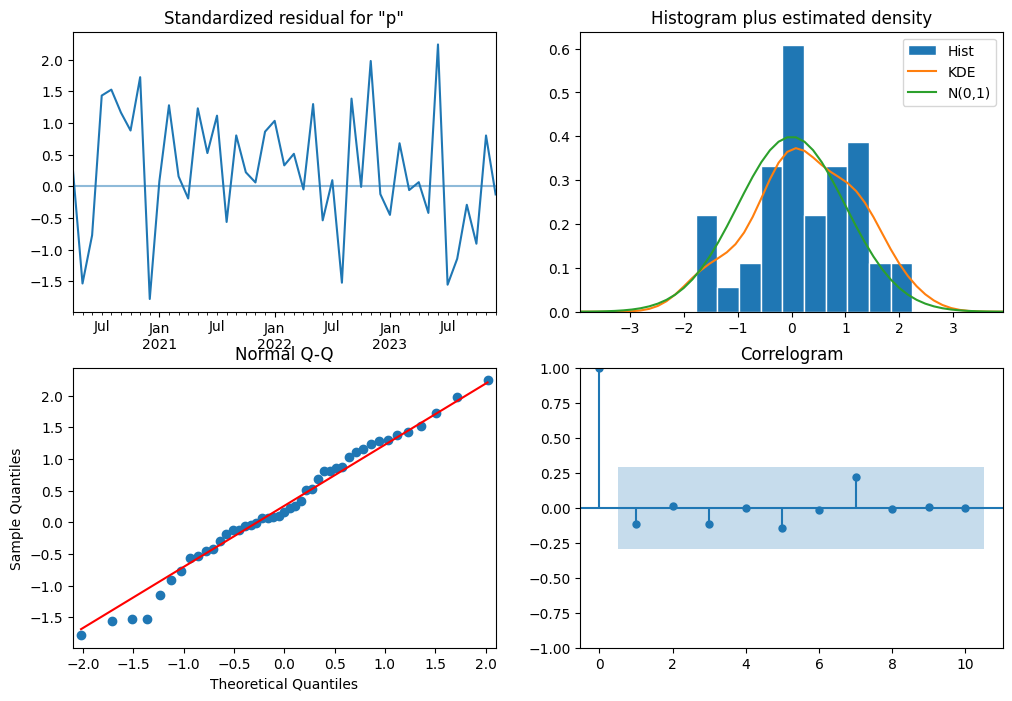

Modèle sauvegardé sous 'best_sarimax_cluster0_parallel.joblib'

=== Traitement du cluster 1 ===
Parallélisation sur 12 cœurs pour 18360 modèles…


Grid Search: 100%|██████████| 18360/18360 [30:37<00:00,  9.99it/s] 


Meilleure combo exogènes : ('taux_rendement_n7', 'loyer_m2_median_n7')
Meilleur ordre (p,d,q)   : (2, 2, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -156.89887391838786


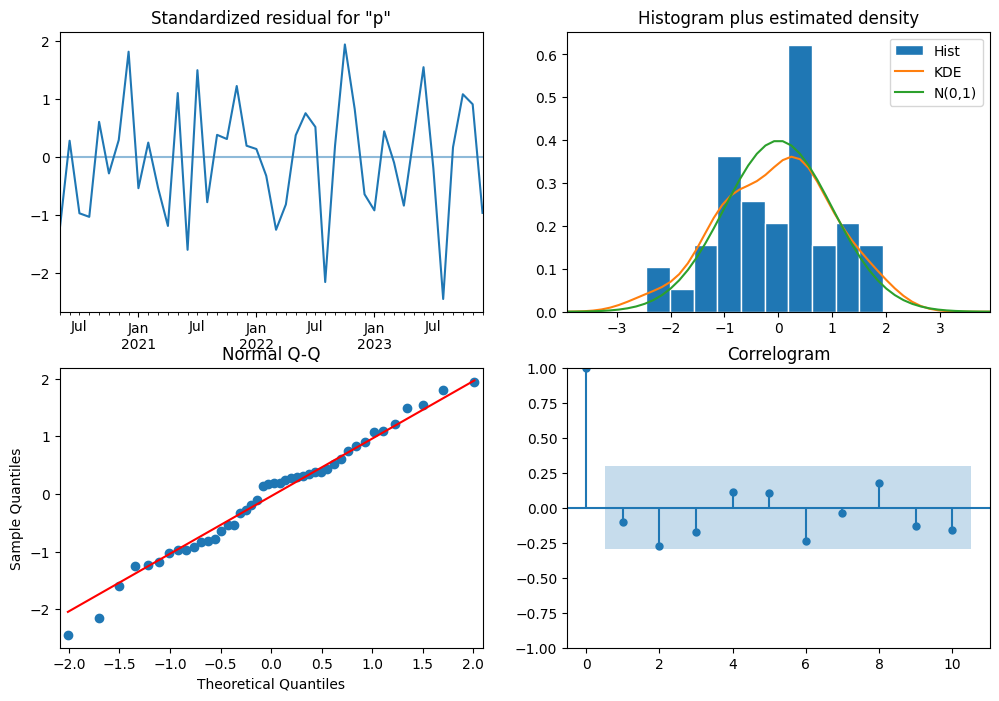

Modèle sauvegardé sous 'best_sarimax_cluster1_parallel.joblib'
Meilleure combo exogènes : ('taux_rendement_n7', 'loyer_m2_median_n7')
Meilleur ordre (p,d,q)   : (2, 2, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -156.89887391838786
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(2, 2, 0)   Log Likelihood                  83.449
Date:                Mon, 02 Jun 2025   AIC                           -156.899
Time:                        18:02:39   BIC                           -147.978
Sample:                    01-01-2020   HQIC                          -153.591
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------

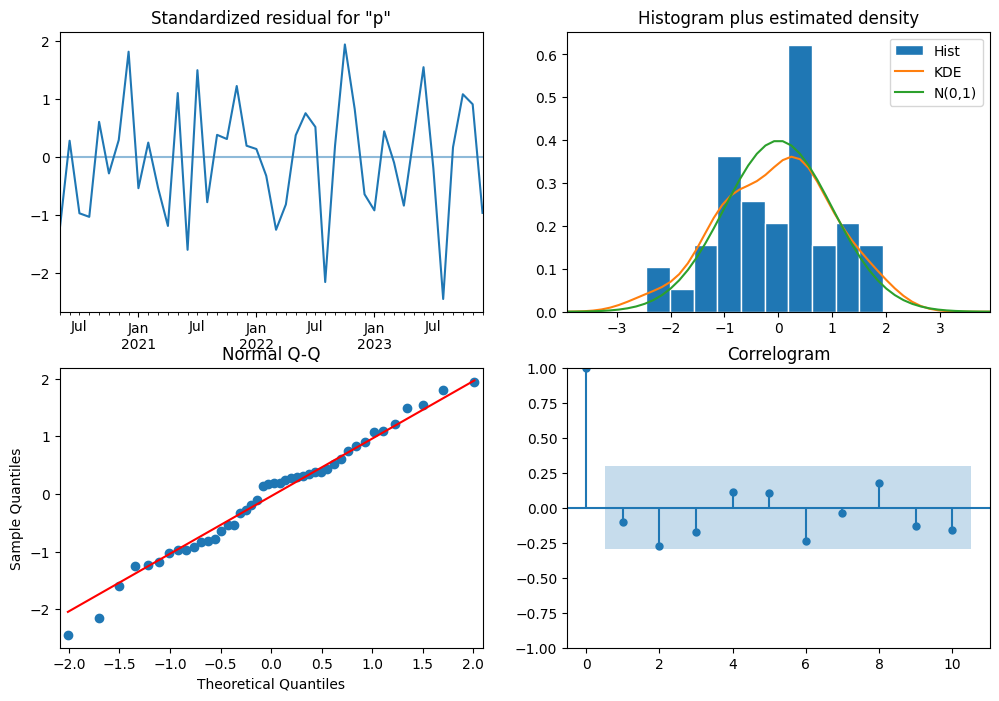

Modèle sauvegardé sous 'best_sarimax_cluster1_parallel.joblib'

=== Traitement du cluster 2 ===
Parallélisation sur 12 cœurs pour 18360 modèles…


Grid Search: 100%|██████████| 18360/18360 [24:40<00:00, 12.40it/s] 


Meilleure combo exogènes : ('z_geo', 'dpeL')
Meilleur ordre (p,d,q)   : (1, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -239.06277396469034


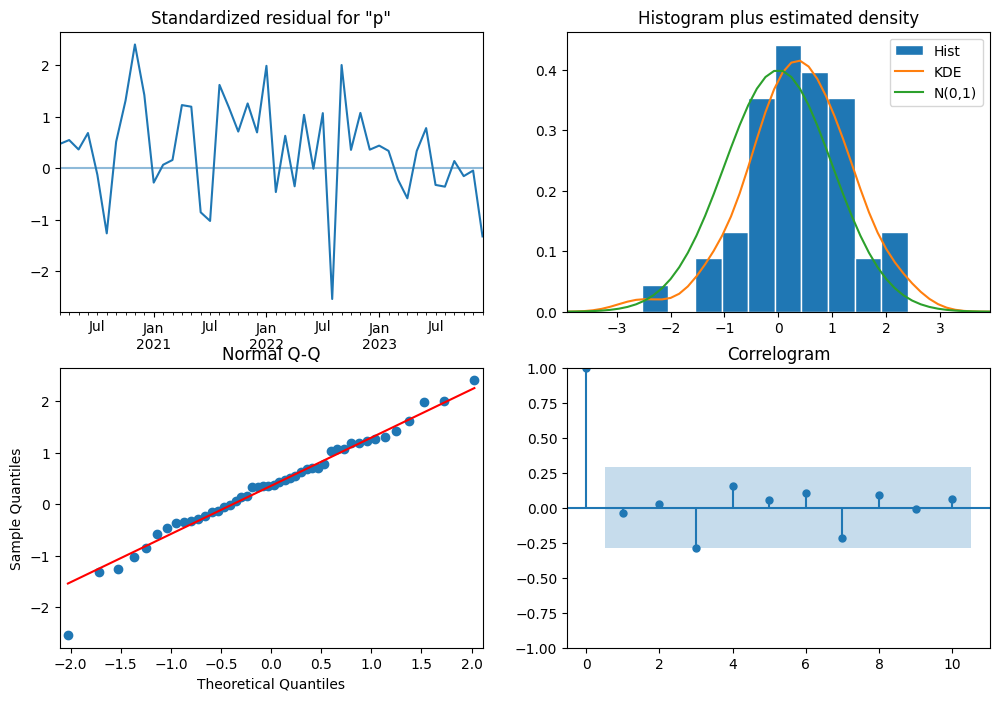

Modèle sauvegardé sous 'best_sarimax_cluster2_parallel.joblib'
Meilleure combo exogènes : ('z_geo', 'dpeL')
Meilleur ordre (p,d,q)   : (1, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -239.06277396469034
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 123.531
Date:                Mon, 02 Jun 2025   AIC                           -239.063
Time:                        18:27:28   BIC                           -231.748
Sample:                    01-01-2020   HQIC                          -236.323
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

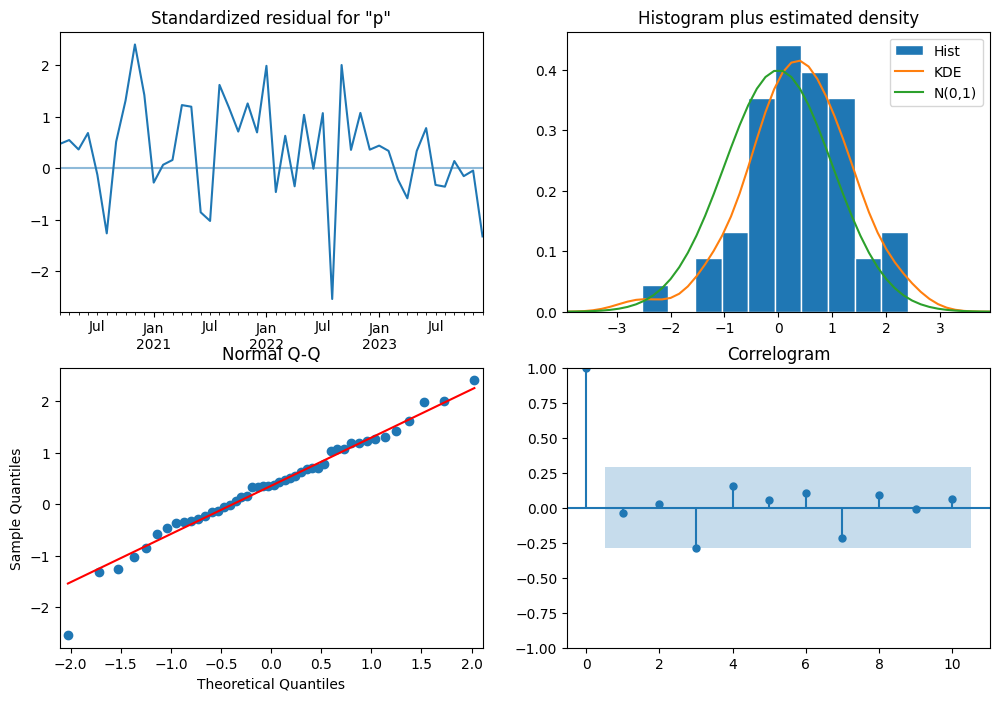

Modèle sauvegardé sous 'best_sarimax_cluster2_parallel.joblib'

=== Traitement du cluster 3 ===
Parallélisation sur 12 cœurs pour 18360 modèles…


Grid Search: 100%|██████████| 18360/18360 [27:23<00:00, 11.17it/s]


Meilleure combo exogènes : ('y_geo', 'x_geo', 'dpeL')
Meilleur ordre (p,d,q)   : (1, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -254.0492111998784


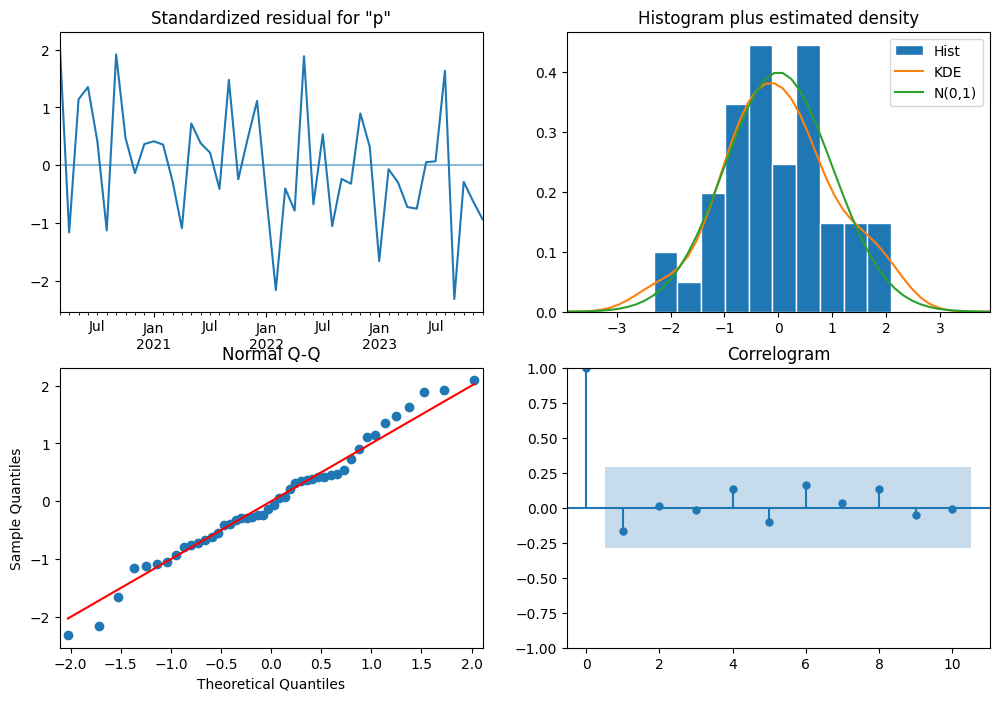

Modèle sauvegardé sous 'best_sarimax_cluster3_parallel.joblib'
Meilleure combo exogènes : ('y_geo', 'x_geo', 'dpeL')
Meilleur ordre (p,d,q)   : (1, 1, 0)
Saisonnalité (P,D,Q,s)    : (0, 0, 0, 12)
AIC                       : -254.0492111998784
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 132.025
Date:                Mon, 02 Jun 2025   AIC                           -254.049
Time:                        18:55:03   BIC                           -244.906
Sample:                    01-01-2020   HQIC                          -250.624
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

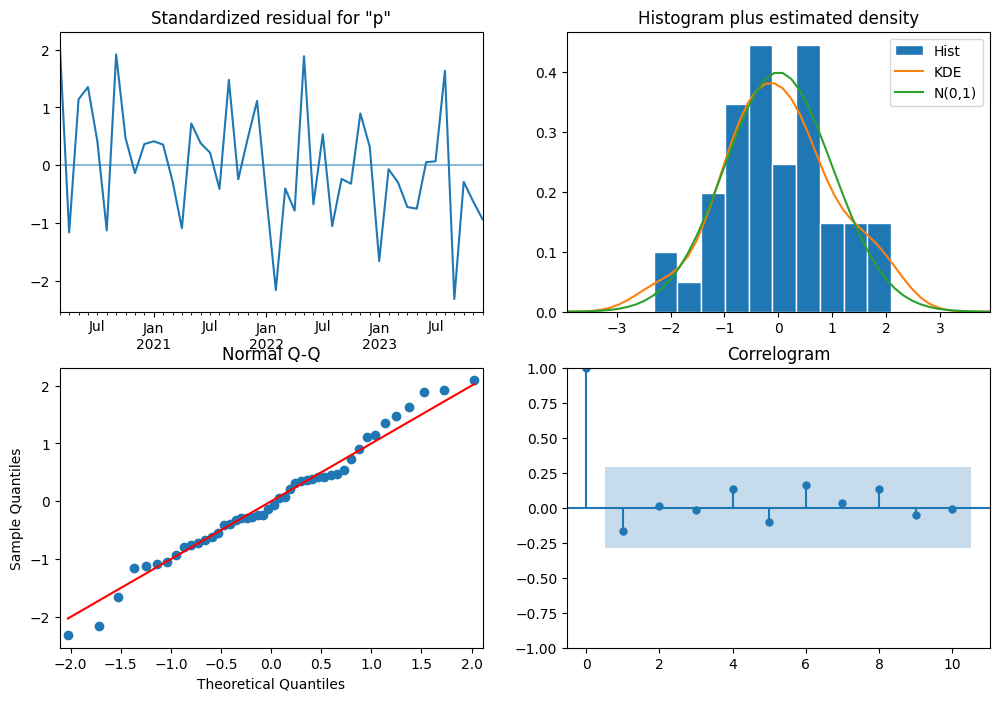

Modèle sauvegardé sous 'best_sarimax_cluster3_parallel.joblib'


In [13]:
import os
import warnings
from itertools import combinations, product

import joblib
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --- Fonctions de grid search parallèle ---

def evaluate_sarimax(endog, exog_df, order, seasonal_order, exog_combo, s):
    try:
        model = SARIMAX(
            endog,
            exog=exog_df[list(exog_combo)],
            order=order,
            seasonal_order=seasonal_order + (s,),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        if (model.pvalues < 0.05).all():
            return (model.aic, order, seasonal_order, exog_combo, model)
    except Exception:
        pass
    return (np.inf, order, seasonal_order, exog_combo, None)


def sarimax_grid_search_parallel(endog, exog_df,
                                 p_values, d_values, q_values,
                                 P_values, D_values, Q_values,
                                 s=12, max_exog_comb=5):
    # Préparation des combinaisons exogènes
    exog_columns = exog_df.columns.tolist()
    exog_combos = []
    for k in range(1, min(max_exog_comb + 1, len(exog_columns) + 1)):
        exog_combos += combinations(exog_columns, k)

    orders = list(product(p_values, d_values, q_values))
    seasonal_orders = list(product(P_values, D_values, Q_values))

    tasks = [
        (order, seasonal_order, exog_combo)
        for order in orders
        for seasonal_order in seasonal_orders
        for exog_combo in exog_combos
    ]

    print(f"Parallélisation sur {os.cpu_count()} cœurs pour {len(tasks)} modèles…")

    results = Parallel(
        n_jobs=os.cpu_count(),
        backend="loky"
    )(
        delayed(evaluate_sarimax)(endog, exog_df, order, seasonal_order, exog_combo, s)
        for order, seasonal_order, exog_combo in tqdm(tasks, desc="Grid Search")
    )

    best = min(results, key=lambda x: x[0])
    best_aic, best_order, best_seasonal, best_combo, best_model = best
    return best_model, best_order, best_seasonal, best_combo, best_aic


# --- Exécution pour clusters 1, 2 et 3 ---
if __name__ == "__main__":
    exog_cols = [
        "taux_rendement_n7", "taux", "loyer_m2_median_n7",
        "y_geo", "x_geo", "z_geo", "dpeL", "nb_pieces", "IPS_primaire"
    ]
    clusters = [0, 1, 2, 3]

    for cluster in clusters:
        print(f"\n=== Traitement du cluster {cluster} ===")
        df_cluster = train_periodique_q12[train_periodique_q12["cluster"] == cluster]
        df_train = train_periodique_q12[train_periodique_q12["cluster"] == cluster]
        df_test  = test_periodique_q12[test_periodique_q12["cluster"] == cluster]
        X_train = df_train[exog_cols]
        y_train = df_train["prix_m2_vente"]
        

        best_model, best_order, best_seasonal, best_exog_combo, best_aic = sarimax_grid_search_parallel(
                endog=y_train,
                exog_df=X_train,
                p_values=[0, 1, 2],
                d_values=[1] if cluster in (0, 2, 3) else [2],
                q_values=[0, 1, 2],
                P_values=[0, 1],
                D_values=[0, 1],
                Q_values=[0, 1],
                s=12,
                max_exog_comb=4
            )

        print("Meilleure combo exogènes :", best_exog_combo)
        print("Meilleur ordre (p,d,q)   :", best_order)
        print("Saisonnalité (P,D,Q,s)    :", best_seasonal + (12,))
        print("AIC                       :", best_aic)

        # Diagnostics
        best_model.plot_diagnostics(figsize=(12, 8))
        plt.show()

        # Sauvegarde modèle
        model_filename = f"best_sarimax_cluster{cluster}_parallel.joblib"
        joblib.dump(best_model, model_filename)
        print(f"Modèle sauvegardé sous '{model_filename}'")

        print("Meilleure combo exogènes :", best_exog_combo)
        print("Meilleur ordre (p,d,q)   :", best_order)
        print("Saisonnalité (P,D,Q,s)    :", best_seasonal + (12,))
        print("AIC                       :", best_aic)
        print(best_model.summary())

        # Diagnostics
        best_model.plot_diagnostics(figsize=(12, 8))
        plt.show()

        # Sauvegarde
        filename = f"best_sarimax_cluster{cluster}_parallel.joblib"
        joblib.dump(best_model, filename)
        print(f"Modèle sauvegardé sous '{filename}'")

#### Chargement des modèles


=== Diagnostics détaillés pour tous les clusters ===

--- Cluster 0 ---
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   47
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 135.251
Date:                Mon, 02 Jun 2025   AIC                           -260.502
Time:                        18:59:41   BIC                           -251.469
Sample:                    02-01-2020   HQIC                          -257.134
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
taux_rendement_n7    -0.0379      0.012     -3.116      0.002      -0.062      -0.014
y_geo                 0.2533      0.0

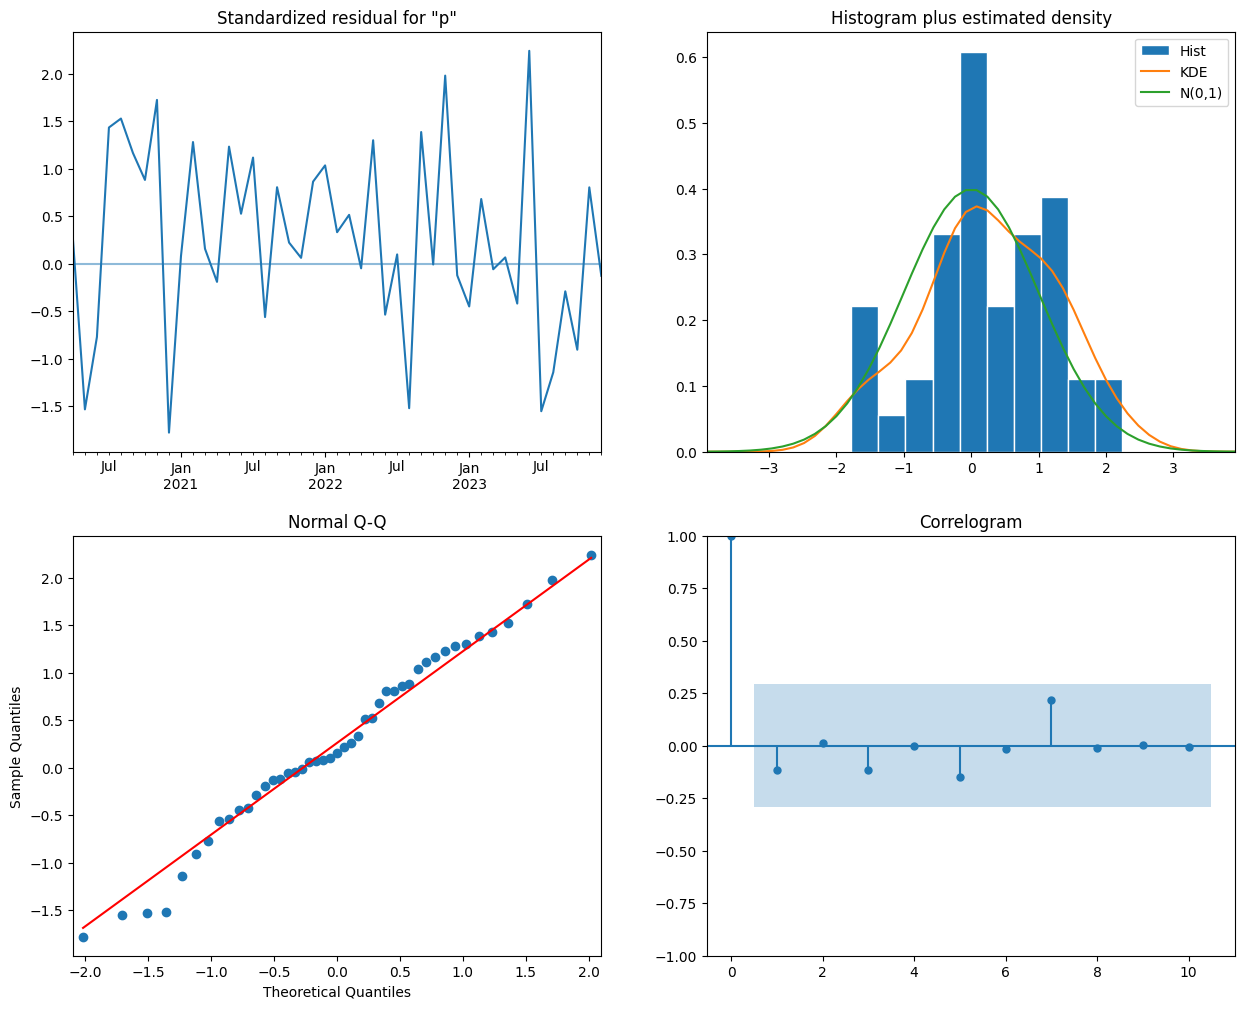


--- Cluster 1 ---
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(2, 2, 0)   Log Likelihood                  83.449
Date:                Mon, 02 Jun 2025   AIC                           -156.899
Time:                        18:59:42   BIC                           -147.978
Sample:                    01-01-2020   HQIC                          -153.591
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
taux_rendement_n7     -0.1843      0.082     -2.237      0.025      -0.346      -0.023
loyer_m2_median_n7    -0.1436      0.066     -2.188      0.029      -0.272      -0.015
a

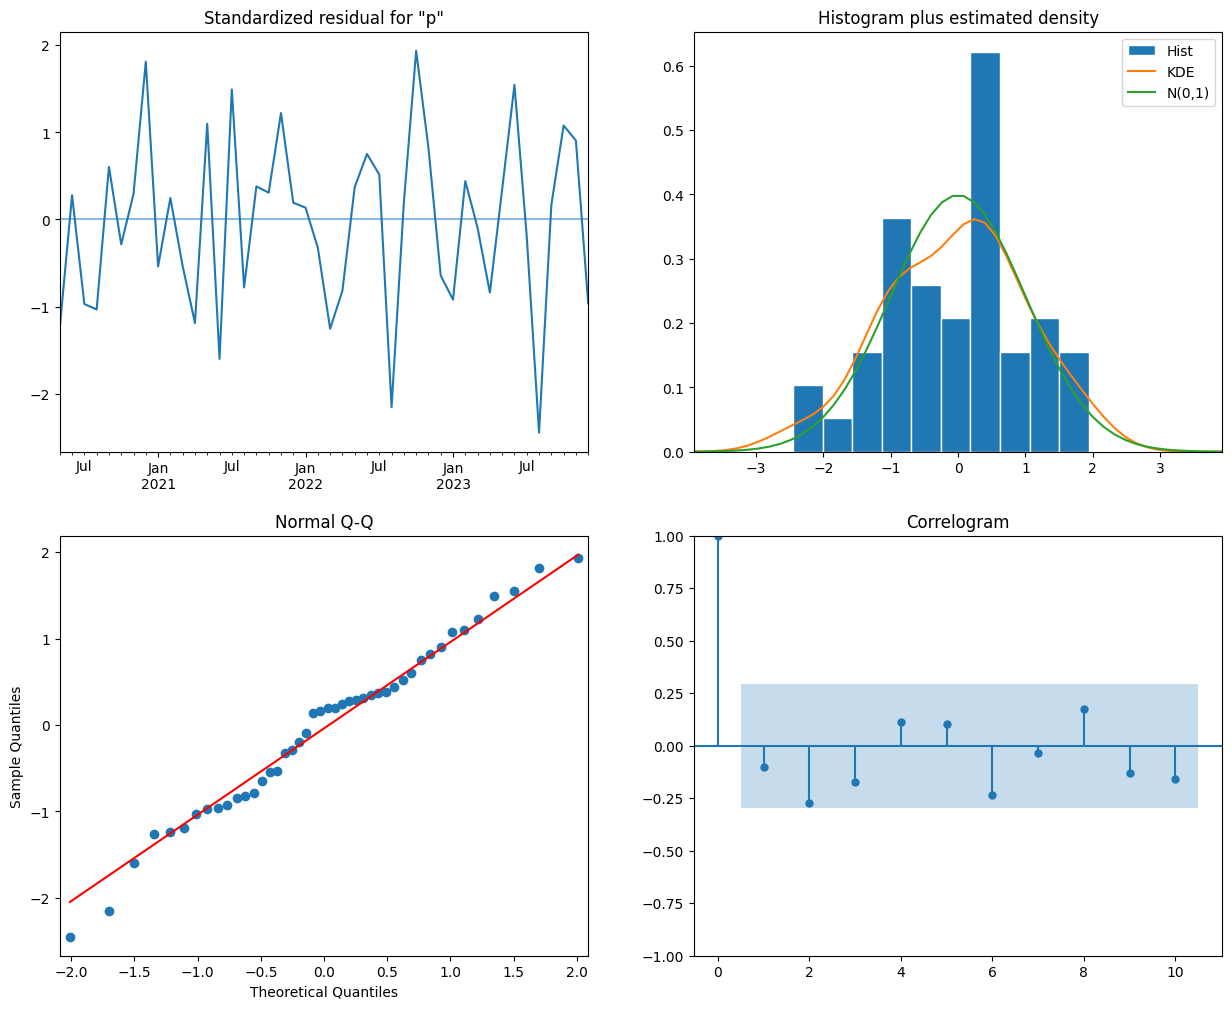


--- Cluster 2 ---
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 123.531
Date:                Mon, 02 Jun 2025   AIC                           -239.063
Time:                        18:59:42   BIC                           -231.748
Sample:                    01-01-2020   HQIC                          -236.323
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
z_geo          0.1639      0.053      3.103      0.002       0.060       0.267
dpeL           0.0694      0.017      4.025      0.000       0.036       0.103
ar.L1         -0.4724      0.112 

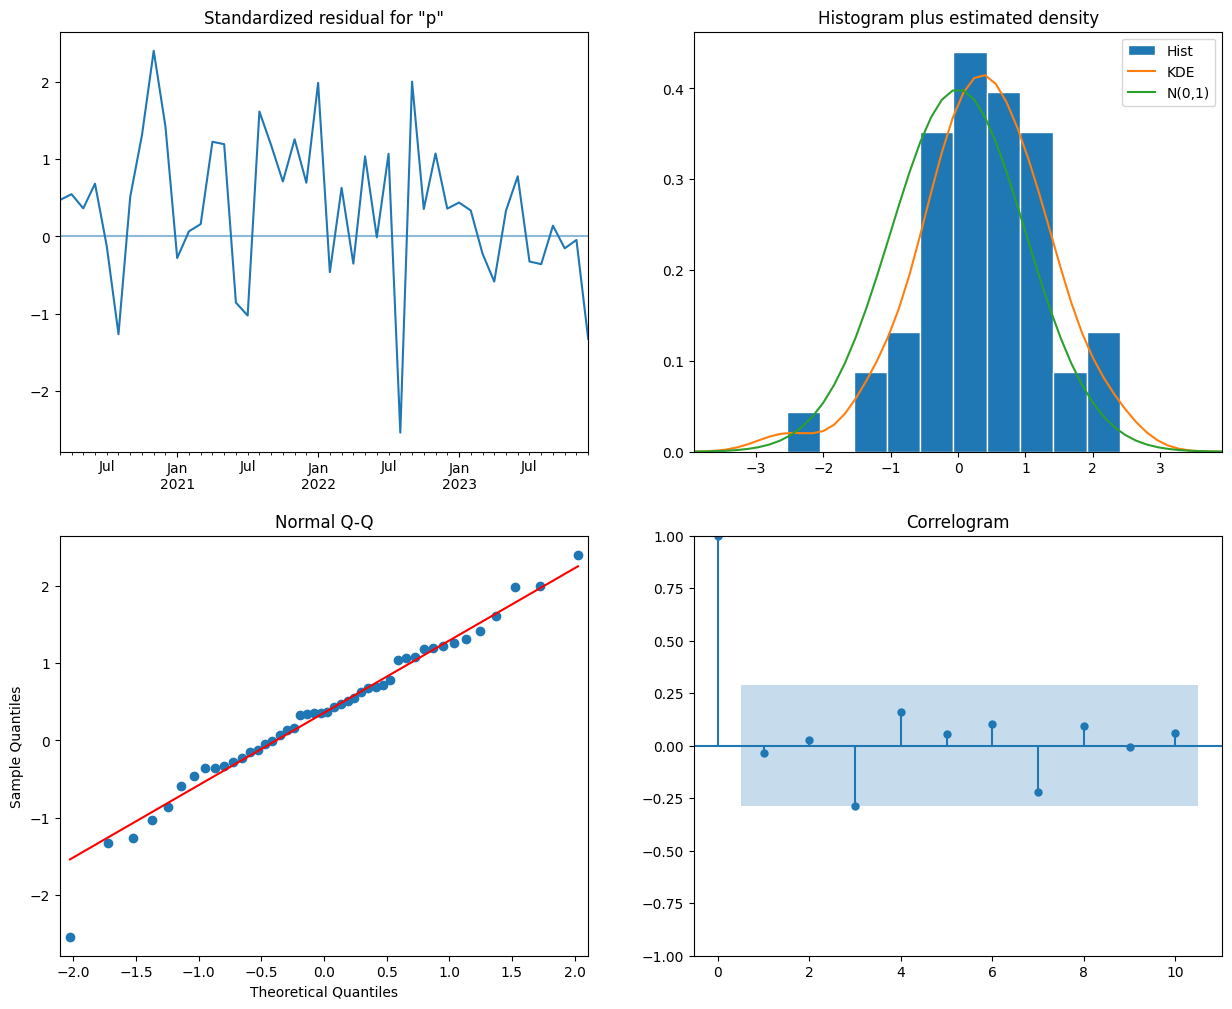


--- Cluster 3 ---
                               SARIMAX Results                                
Dep. Variable:          prix_m2_vente   No. Observations:                   48
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 132.025
Date:                Mon, 02 Jun 2025   AIC                           -254.049
Time:                        18:59:43   BIC                           -244.906
Sample:                    01-01-2020   HQIC                          -250.624
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y_geo          0.2766      0.115      2.401      0.016       0.051       0.502
x_geo         -0.2731      0.026    -10.654      0.000      -0.323      -0.223
dpeL          -0.0672      0.026 

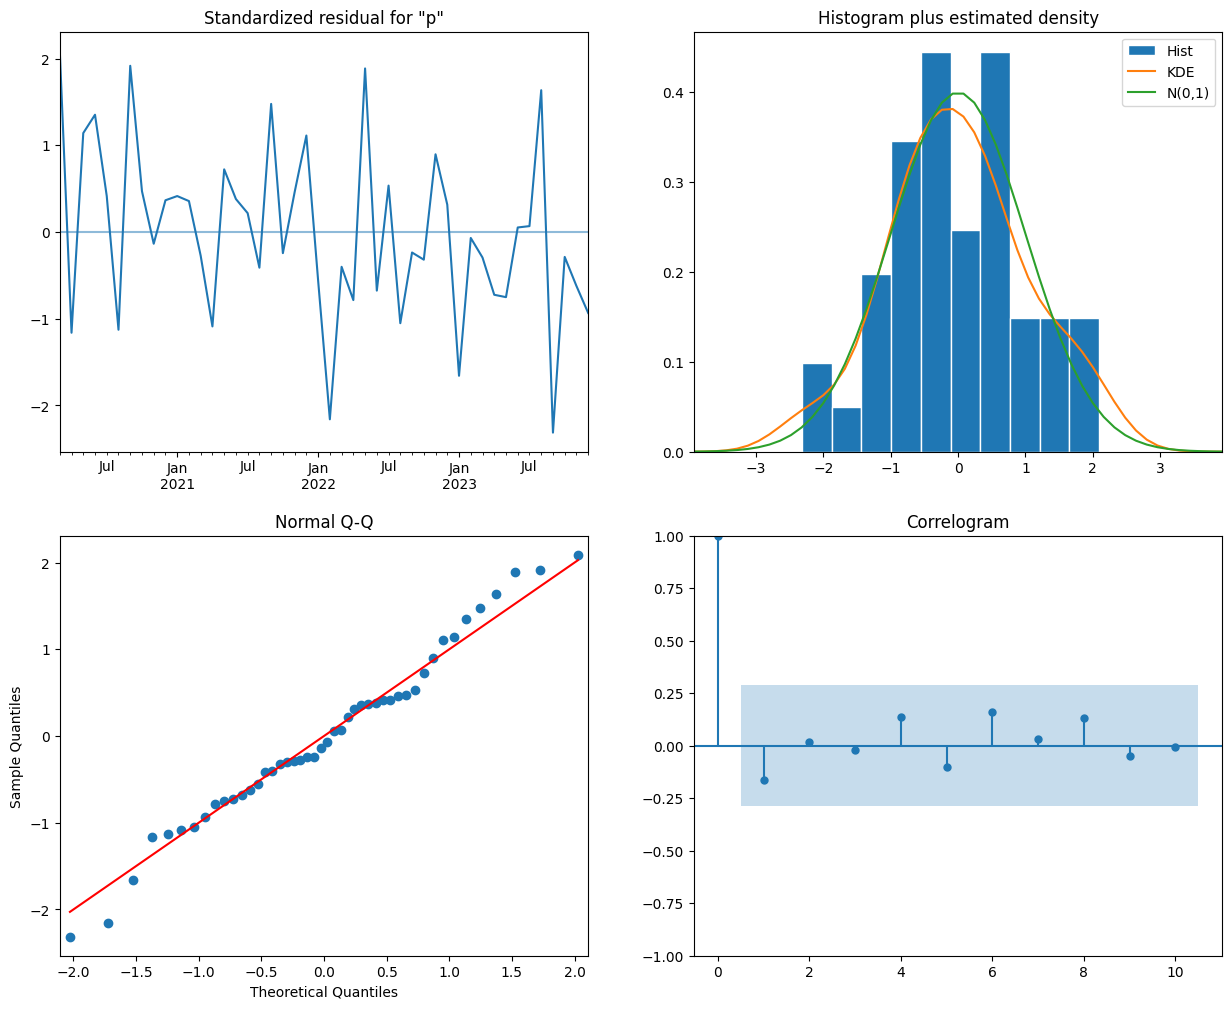

In [16]:
import joblib
clusters = [0, 1, 2, 3]
    # Section Chargement et diagnostics de tous les modèles
print("\n=== Diagnostics détaillés pour tous les clusters ===")
for cluster in clusters:
    filename = f"C:/Users/charl/Downloads/best_sarimax_cluster{cluster}_parallel.joblib"
    model = joblib.load(filename)
    print(f"\n--- Cluster {cluster} ---")
    print(model.summary())
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()


## Prédictions et diagnostique du prix m2 des clusters 


=== Cluster 0: Banlieue - Zone Mixte ===


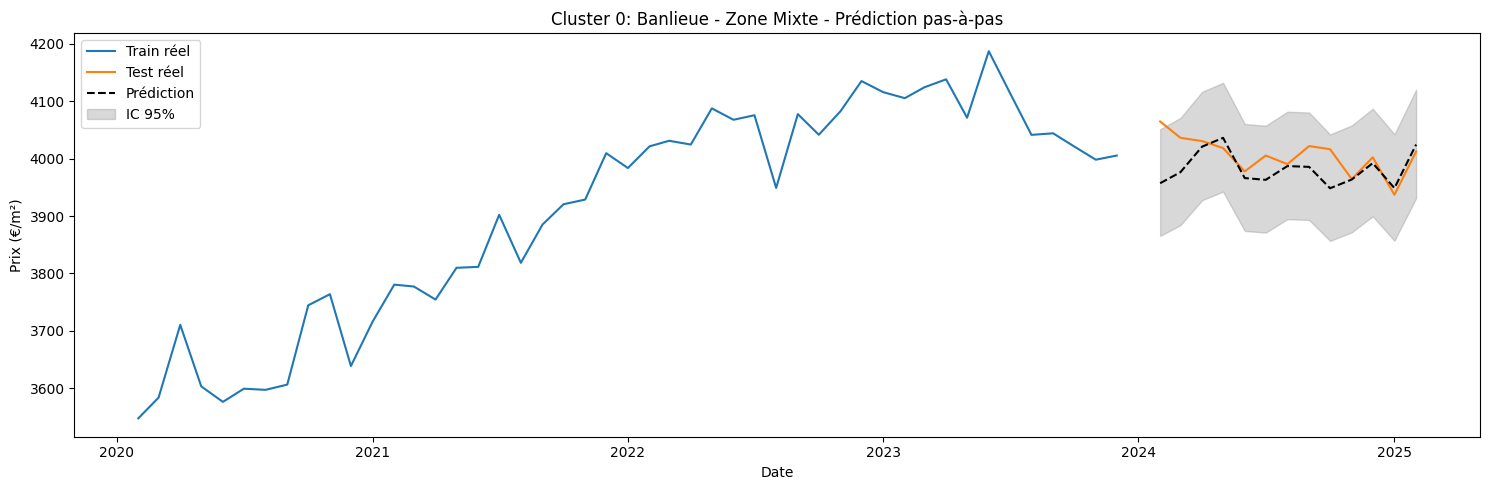

Cluster 0 – MAE : 30.11 €/m²

=== Cluster 1: Centre Urbain établis, zones résidentielles ===


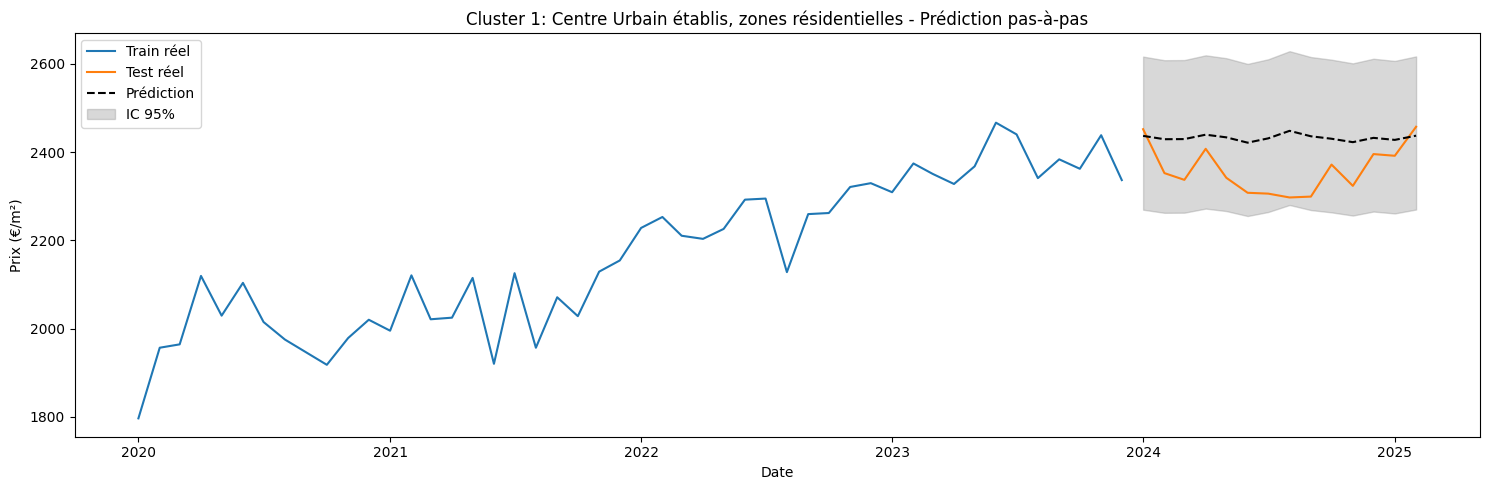

Cluster 1 – MAE : 77.54 €/m²

=== Cluster 2: Zone rurale, petites villes stagnantes ===


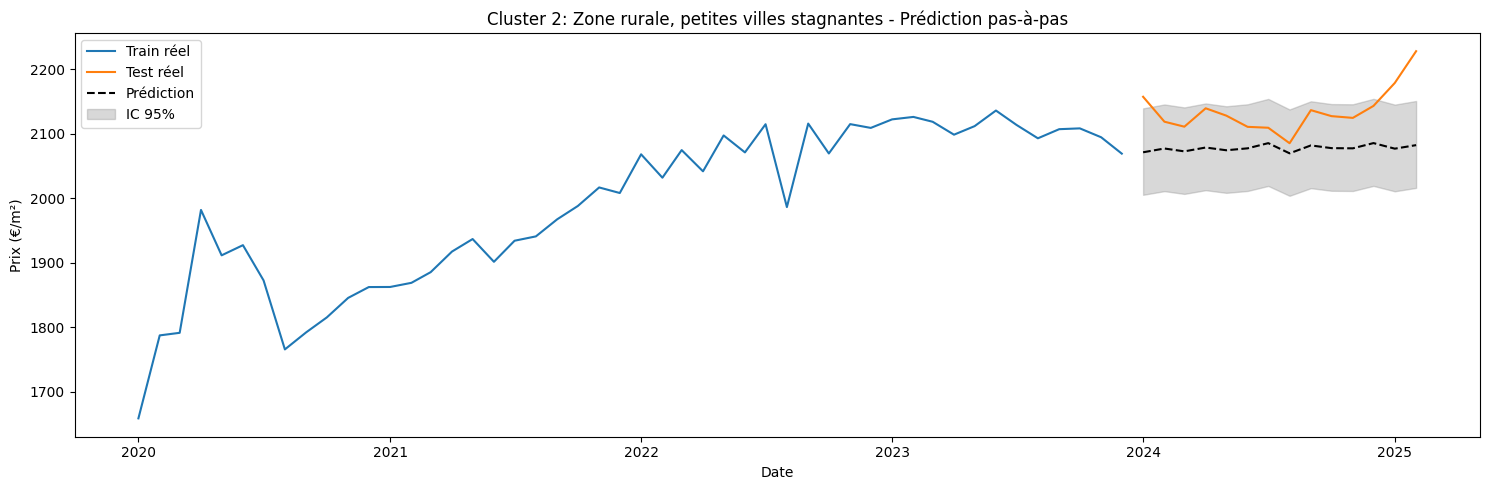

Cluster 2 – MAE : 57.81 €/m²

=== Cluster 3: Zones tendues, secteurs spéculatifs ===


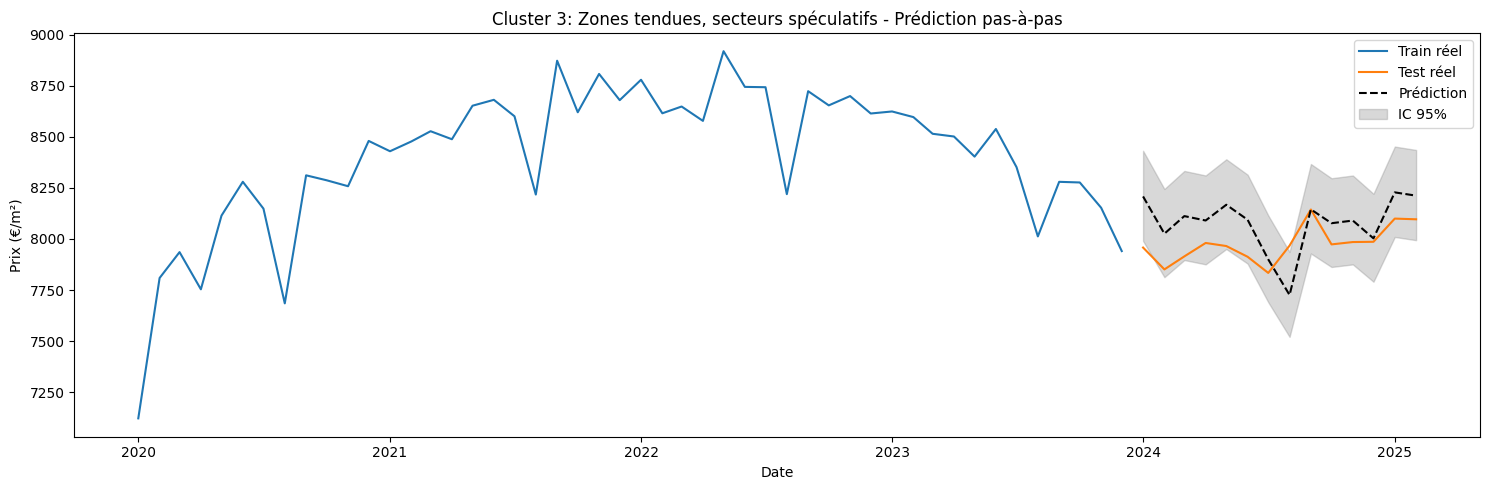

Cluster 3 – MAE : 135.23 €/m²


In [19]:
from sklearn.metrics import mean_absolute_error
dico = {"0": "Banlieue - Zone Mixte",
        "1":"Centre Urbain établis, zones résidentielles",
        "2":"Zone rurale, petites villes stagnantes",
        "3": "Zones tendues, secteurs spéculatifs"}
clusters   = [0, 1, 2, 3]
exog_cols  = [
    "taux_rendement_n7", "taux", "loyer_m2_median_n7",
    "y_geo", "x_geo", "z_geo", "dpeL", "nb_pieces", "IPS_primaire"
]

for cluster in clusters:
    print(f"\n=== Cluster {cluster}: {dico[str(cluster)]} ===")

    # 1) Chargement des données train / test
    df_train = train_periodique_q12.query("cluster == @cluster")
    df_test  = test_periodique_q12 .query("cluster == @cluster")
    
    # 2) Séries et exogènes
    y_train   = df_train["prix_m2_vente"]
    y_test    = df_test ["prix_m2_vente"]

    # 3) Charger le modèle sauvegardé pour CE cluster
    model = joblib.load(f"best_sarimax_cluster{cluster}_parallel.joblib")

    # 4) Prépare les exogènes de test selon le modèle
    exog_test = df_test[model.model.exog_names]

    # 5) Boucle pas-à-pas pour récupérer mean / CI
    preds, lowers, uppers = [], [], []
    for t in range(len(exog_test)):
        xt = exog_test.iloc[t:t+1]
        pf = model.get_forecast(steps=1, exog=xt).summary_frame()
        # back-transform si tu as log-transformé en amont
        m = np.exp(pf["mean"].iloc[0])
        l = np.exp(pf["mean_ci_lower"].iloc[0])
        u = np.exp(pf["mean_ci_upper"].iloc[0])
        preds.append(m); lowers.append(l); uppers.append(u)

    df_pred = pd.DataFrame({
        "mean":  preds,
        "lower": lowers,
        "upper": uppers
    }, index=df_test.index[: len(preds)])

    # 6) Séries en euros
    y_train_eur = np.exp(y_train)
    y_test_eur  = np.exp(y_test)

    # 7) Plot prédiction
    plt.figure(figsize=(15,5))
    plt.plot(y_train_eur, label="Train réel")
    plt.plot(y_test_eur,  label="Test réel")
    plt.plot(df_pred["mean"], "k--", label="Prédiction")
    plt.fill_between(df_pred.index, df_pred["lower"], df_pred["upper"],
                     color="gray", alpha=0.3, label="IC 95%")
    plt.title(f"Cluster {cluster}: {dico[str(cluster)]} - Prédiction pas-à-pas")
    plt.xlabel("Date")
    plt.ylabel("Prix (€/m²)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8) MAE
    mae = mean_absolute_error(y_test_eur, df_pred["mean"])
    print(f"Cluster {cluster} – MAE : {mae:.2f} €/m²")

# # 9) Diagnostics détaillés
# print("\n=== Diagnostics détaillés pour tous les clusters ===")
# for cluster in clusters:
#     model = joblib.load(f"best_sarimax_cluster{cluster}_parallel.joblib")
#     print(f"\n--- Cluster {cluster} ---")
#     print(model.summary())
#     model.plot_diagnostics(figsize=(15,12))
#     plt.show()


## Evaluation de la performance

### Evaluation de la précision

In [21]:
# ─── EVALUATION DES MODELES PAR CLUSTER ─────────────────────────────────────────

from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import joblib

clusters = [0, 1, 2, 3]
results  = []

for cluster in clusters:
    # 1) Données de test pour le cluster
    df_test = test_periodique_q12.query("cluster == @cluster")
    y_true  = np.exp(df_test["prix_m2_vente"])

    # 2) Chargement du modèle optimisé
    model = joblib.load(f"best_sarimax_cluster{cluster}_parallel.joblib")

    # 3) Préparation des exogènes & forecast
    exog_test = df_test[model.model.exog_names]
    fc        = model.get_forecast(steps=len(exog_test), exog=exog_test)
    y_pred    = np.exp(fc.predicted_mean)

    # 4) Calcul des métriques
    mae  = mean_absolute_error(y_true, y_pred)
    mape = (100 * np.abs((y_true - y_pred) / y_true)).mean()

    results.append({
        "Cluster": cluster,
        "Cluster_description": dico[str(cluster)],
        "MAE (€/m²)": mae,
        "MAPE (%)": mape
    })

# 5) Affichage résumé
metrics_df = pd.DataFrame(results)
display(metrics_df)


Cluster                          Cluster_description  MAE (€/m²)  MAPE (%)
0        0                        Banlieue - Zone Mixte   30.112532  1.029448
1        1  Centre Urbain établis, zones résidentielles   72.197995  3.099478
2        2       Zone rurale, petites villes stagnantes   64.495322  2.998046
3        3          Zones tendues, secteurs spéculatifs  130.631354  1.641367

### Evaluation du surapprentissage <-- Cette partie est en cours 


########### CLUSTER 0: Banlieue - Zone Mixte ####################

[Cluster 0] Seuil IQR haut = 4574.5 €/m²
MSE in  : 2,163.9
MSE out : 1,835.3   MAE out : 30.1


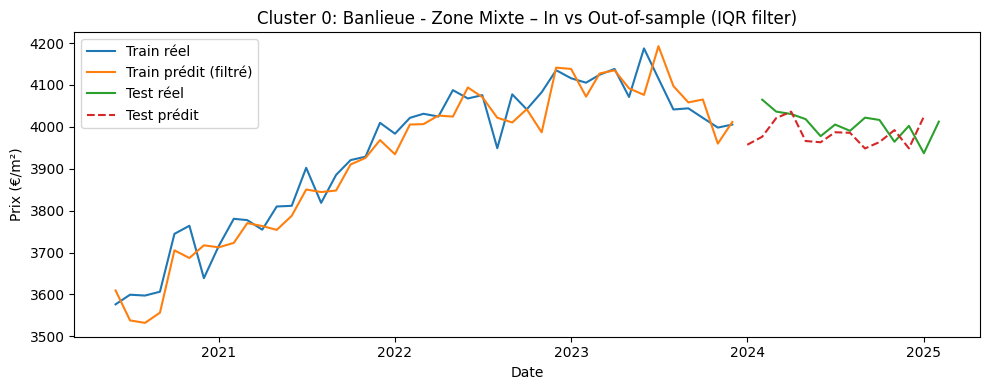


########### CLUSTER 1: Centre Urbain établis, zones résidentielles ####################

[Cluster 1] Seuil IQR haut = 2796.7 €/m²
MSE in  : 6,406.7
MSE out : 7,167.4   MAE out : 72.2


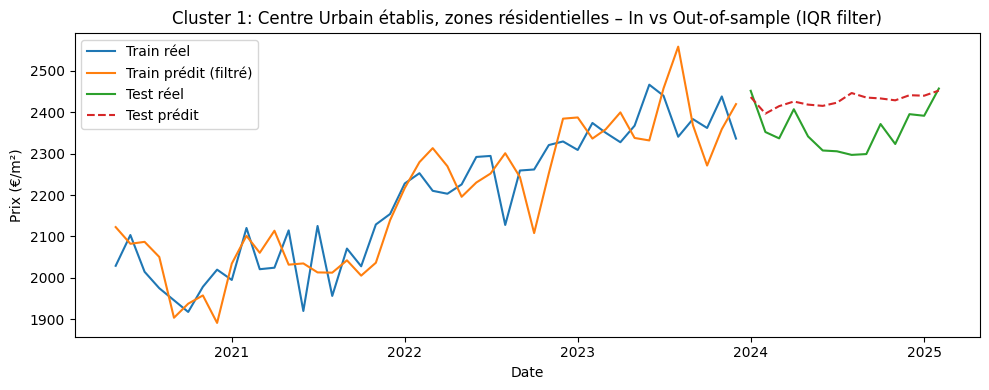


########### CLUSTER 2: Zone rurale, petites villes stagnantes ####################

[Cluster 2] Seuil IQR haut = 2420.0 €/m²
MSE in  : 1,090.3
MSE out : 5,191.9   MAE out : 64.5


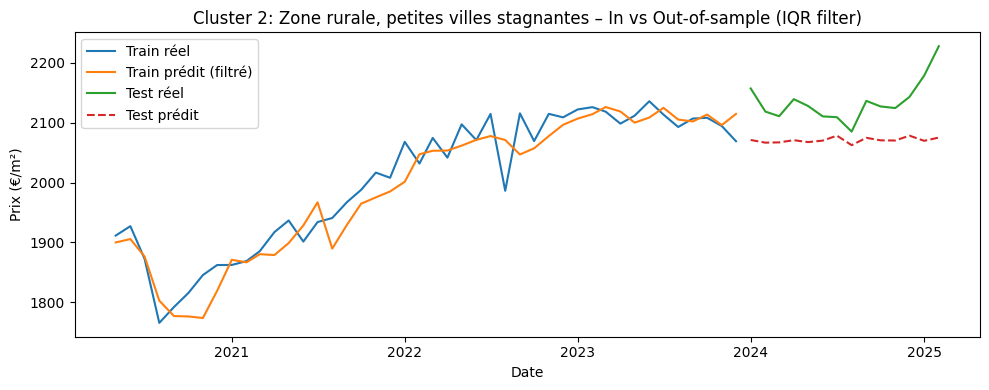


########### CLUSTER 3: Zones tendues, secteurs spéculatifs ####################

[Cluster 3] Seuil IQR haut = 9289.2 €/m²
MSE in  : 12,328.9
MSE out : 22,610.4   MAE out : 130.6


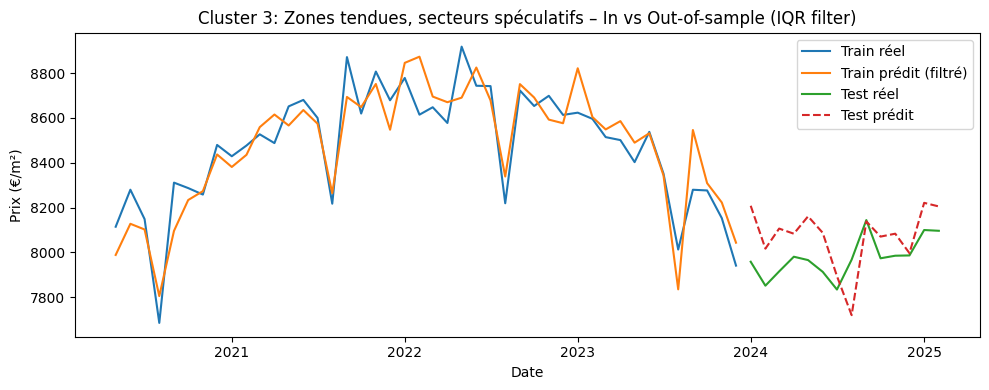

In [23]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

'''
On applique un filtre basé sur l'écart interquartile (IQR) pour détecter et masquer 
les prédictions in-sample aberrantes (exponentiées). Ce filtre est robuste, car 
il s'adapte à la distribution locale des prédictions, sans imposer de seuil fixe arbitraire.
'''

clusters = [0, 1, 2, 3]

for n,o in zip(clusters,dico.values()):
    print(f"\n########### CLUSTER {n}: {o} ####################\n")

    # 1) Données train/test
    df_train = train_periodique_q12.query("cluster == @n")
    df_test  = test_periodique_q12.query("cluster == @n")

    # 2) Séries réelles (log → €)
    y_train_log = df_train["prix_m2_vente"]
    y_train_eur = np.exp(y_train_log)
    y_test_eur  = np.exp(df_test["prix_m2_vente"])

    # 3) Modèle
    model = joblib.load(f"best_sarimax_cluster{n}_parallel.joblib")

    # 4) Exogènes
    exog_train = df_train[model.model.exog_names]
    exog_test  = df_test[model.model.exog_names]

    # 5) Prédiction in-sample one-step
    pred_ins = model.get_prediction(
        start=df_train.index[0],
        end=df_train.index[-1],
        exog=exog_train,
        dynamic=False
    )
    y_pred_ins = np.exp(pred_ins.predicted_mean)

    # 6) Détection des valeurs aberrantes (filtrage IQR)
    Q1 = y_pred_ins.quantile(0.25)
    Q3 = y_pred_ins.quantile(0.75)
    IQR = Q3 - Q1
    seuil_sup = Q3 + 1.5 * IQR

    print(f"[Cluster {n}] Seuil IQR haut = {seuil_sup:.1f} €/m²")

    # Masquage des valeurs aberrantes pour affichage (pas pour le calcul)
    y_pred_ins_display = y_pred_ins.copy()
    y_pred_ins_display[y_pred_ins > seuil_sup] = np.nan

    # 7) Suppression du premier point
    y_train_cut = y_train_eur.iloc[4:]
    y_pred_cut  = y_pred_ins_display.iloc[4:]

    # 8) Prévision out-of-sample
    pred_out = model.get_forecast(steps=len(df_test), exog=exog_test)
    y_pred_out = np.exp(pred_out.predicted_mean)

    # 9) Erreurs (calculées sur les vraies prédictions, non filtrées)
    valid_mask = (~y_pred_cut.isna()) & (~y_train_cut.isna())
    mse_in = mean_squared_error(y_train_cut[valid_mask], y_pred_cut[valid_mask])
    mse_out = mean_squared_error(y_test_eur, y_pred_out)
    mae_out = mean_absolute_error(y_test_eur, y_pred_out)
    print(f"MSE in  : {mse_in:,.1f}")
    print(f"MSE out : {mse_out:,.1f}   MAE out : {mae_out:,.1f}")

    # 10) Tracé
    plt.figure(figsize=(10, 4))
    plt.plot(y_train_cut.index, y_train_cut, label="Train réel")
    plt.plot(y_pred_cut.index,  y_pred_cut,  label="Train prédit (filtré)")
    plt.plot(y_test_eur.index,  y_test_eur,  label="Test réel")
    plt.plot(y_pred_out.index,  y_pred_out,  label="Test prédit", linestyle="--")
    plt.title(f"Cluster {n}: {o} – In vs Out-of-sample (IQR filter)")
    plt.xlabel("Date")
    plt.ylabel("Prix (€/m²)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Enregistrement des résultats

## Prophet cluster 2 -Zone Rurale

20:15:14 - cmdstanpy - INFO - Chain [1] start processing
20:15:14 - cmdstanpy - INFO - Chain [1] done processing


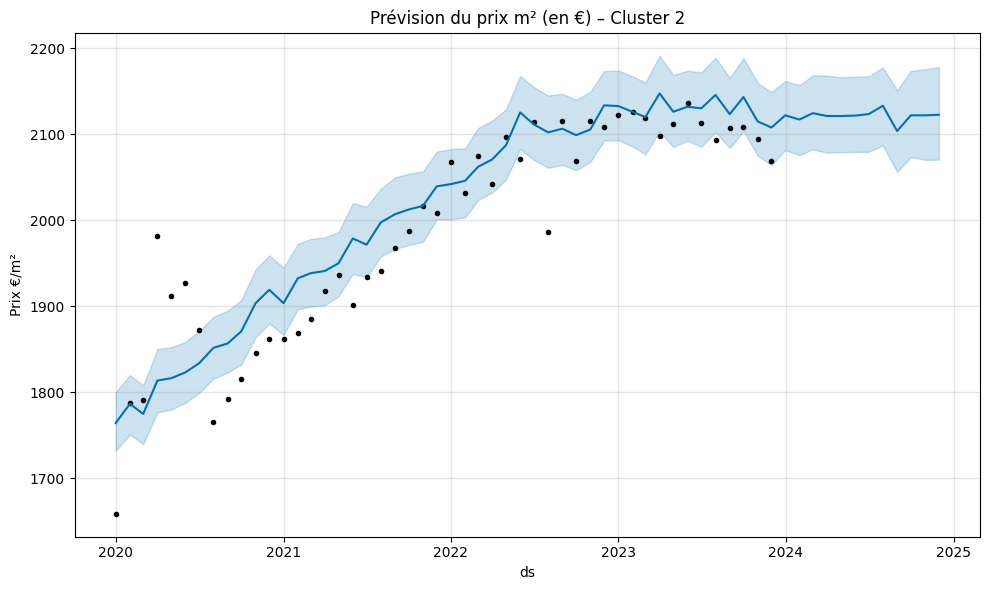

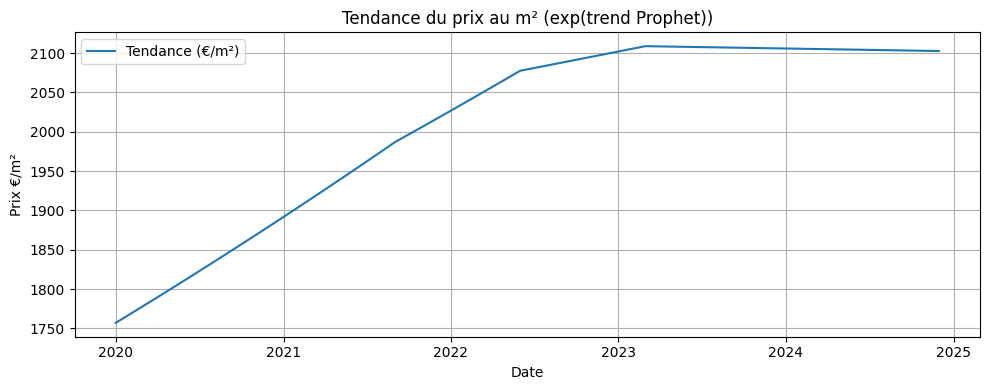

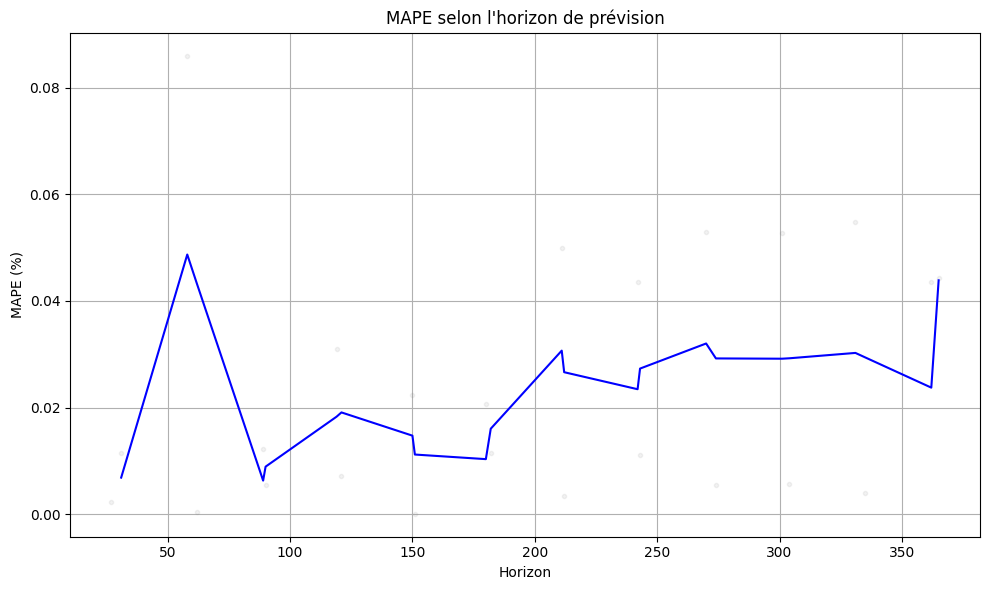

  horizon      mape        mae        rmse
0 31 days  0.006864  14.556299   17.479406
1 58 days  0.048715  97.529517  122.001419
2 62 days  0.043166  85.755524  120.793027
3 89 days  0.006303  13.335391   18.380909
4 90 days  0.008917  18.870909   20.167513
OrderedDict([('y_geo', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': -0.041649629365565544, 'std': 0.03729331186167315, 'mode': 'multiplicative'}), ('x_geo', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': -0.05560816988718812, 'std': 0.03540299033064303, 'mode': 'multiplicative'})])


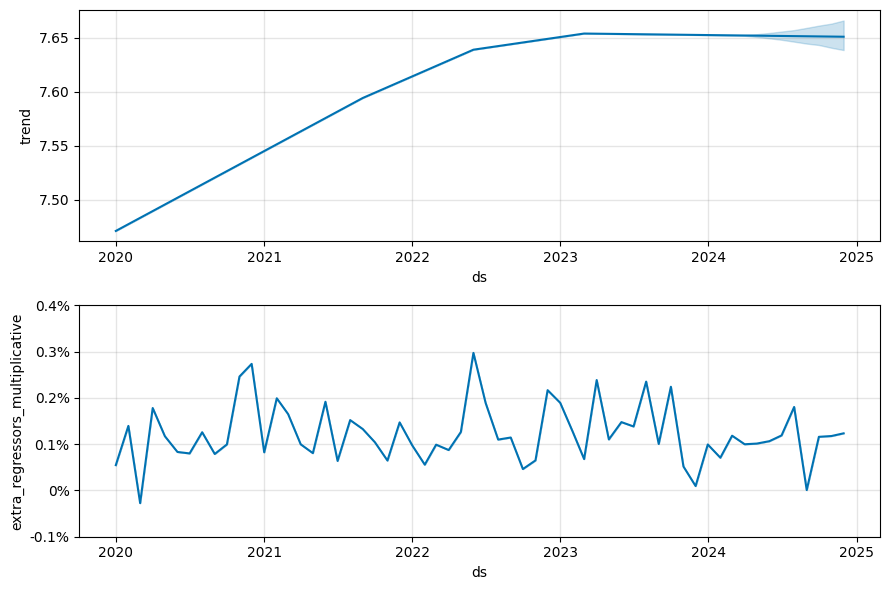

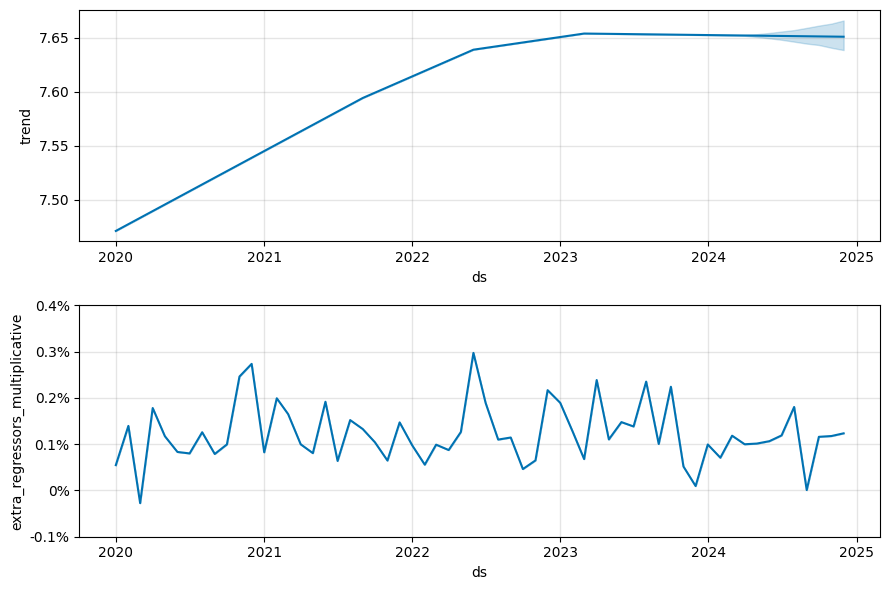

In [26]:
# 1. Imports et chargement -------------------------------------------------
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot_components
import matplotlib.pyplot as plt
import numpy as np

cluster = 2
df_cluster = train_periodique_q12[train_periodique_q12["cluster"] == cluster].copy().reset_index()
exog_cols = ["y_geo", "x_geo"]

# Renommage + sélection
df_train_prophet = df_cluster.rename(columns={'date': 'ds', 'prix_m2_vente': 'y'})[['ds', 'y'] + exog_cols]

# 2. Ajustement du modèle --------------------------------------------------
changepoints = ['2021-09-01',  # Fin de la croissance post-COVID
    '2022-06-01',  # Plateau visible
    '2023-03-01'   # Début de l’inflexion à la baisse
]
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,
    changepoints=changepoints,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    interval_width=0.8
)

# Ajouter les régresseurs
for reg in exog_cols:
    m.add_regressor(reg)

# Entraînement
m.fit(df_train_prophet)

# 3. Prévision -------------------------------------------------------------
future = m.make_future_dataframe(periods=12, freq='M')

# Générer des valeurs futures exogènes avec une légère variation
for col in exog_cols:
    last_val = df_train_prophet[col].iloc[-1]
    noise = np.random.normal(0, 0.01, size=len(future))
    future[col] = last_val + noise

forecast = m.predict(future)

# Revenir à l’échelle réelle (log inverse)
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.exp(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
m.history['y'] = np.exp(m.history['y'])

# 4. Visualisation de la prévision -----------------------------------------
fig1 = m.plot(forecast)
plt.title(f'Prévision du prix m² (en €) – Cluster {cluster}')
plt.ylabel("Prix €/m²")
plt.tight_layout()
plt.show()

# 5. Tendance (exp(trend)) -------------------------------------------------
df_trend = forecast[['ds', 'trend']].copy()
df_trend['trend_euros'] = np.exp(df_trend['trend'])

plt.figure(figsize=(10, 4))
plt.plot(df_trend['ds'], df_trend['trend_euros'], label='Tendance (€/m²)')
plt.xlabel("Date")
plt.ylabel("Prix €/m²")
plt.title("Tendance du prix au m² (exp(trend Prophet))")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# 6. Cross-validation ------------------------------------------------------
df_cv = cross_validation(
    model=m,
    initial='730 days',
    period='180 days',
    horizon='365 days',
    parallel="processes"
)

df_p = performance_metrics(df_cv)

fig2 = plot_cross_validation_metric(df_cv, metric='mape')
plt.title("MAPE selon l'horizon de prévision")
plt.ylabel("MAPE (%)")
plt.xlabel("Horizon")
plt.tight_layout()
plt.show()

print(df_p[['horizon', 'mape', 'mae', 'rmse']].head())
print(m.extra_regressors)

# 7. Composants saisonniers, tendance, changepoints
plot_components(m, forecast)


20:14:53 - cmdstanpy - INFO - Chain [1] start processing
20:14:53 - cmdstanpy - INFO - Chain [1] done processing


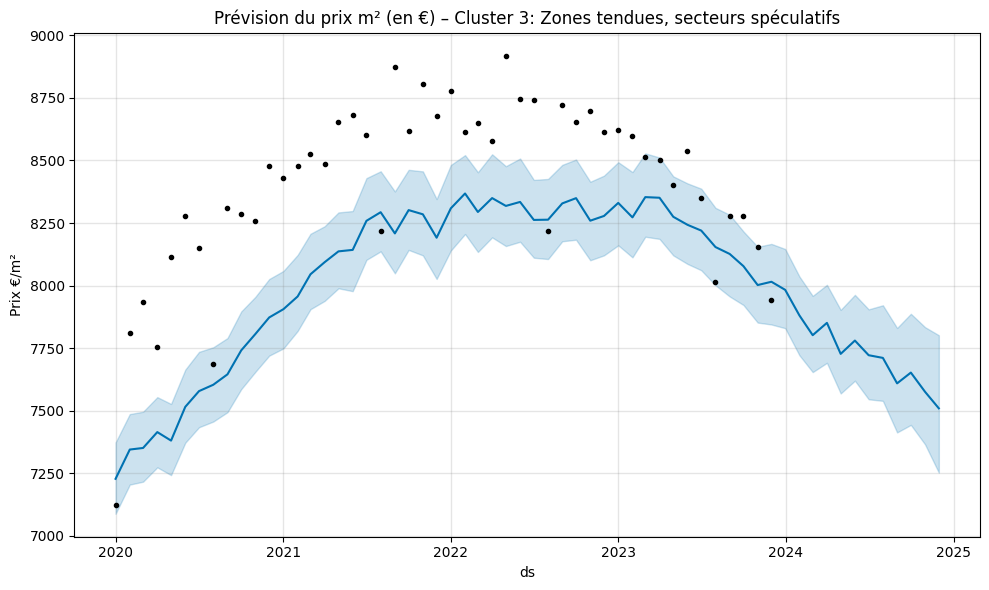

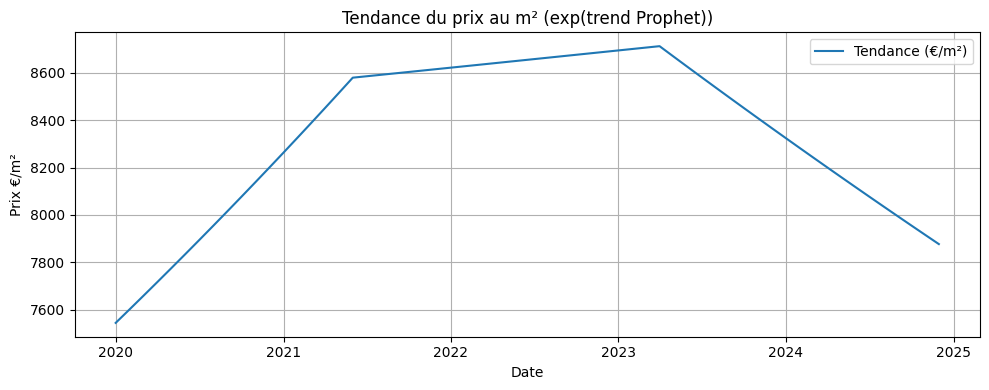

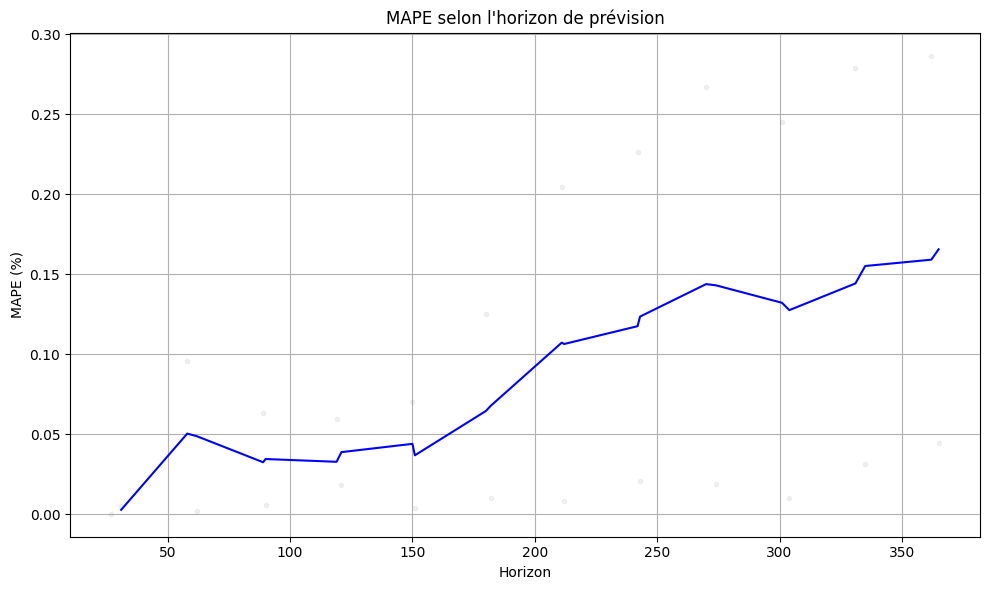

  horizon      mape         mae        rmse
0 31 days  0.002631   22.695893   31.334990
1 58 days  0.050310  414.543816  555.811445
2 62 days  0.048626  399.994006  555.032085
3 89 days  0.032381  282.344283  388.694812
4 90 days  0.034399  299.458105  390.115019
OrderedDict([('y_geo', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': 0.08555780305508355, 'std': 0.04144917442364013, 'mode': 'multiplicative'}), ('dpeL', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': 0.1305779476869162, 'std': 0.20957789527196782, 'mode': 'multiplicative'}), ('taux_rendement_n7', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': 0.15669543336514247, 'std': 0.48426802154592025, 'mode': 'multiplicative'}), ('loyer_m2_median_n7', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': -0.059304257424827034, 'std': 1.0747571798152922, 'mode': 'multiplicative'}), ('taux', {'prior_scale': 10.0, 'standardize': 'auto', 'mu': 9.25185853854297e-18, 'std': 1.0105823052798226, 'mode': 'multiplicative'}), ('nb_piece

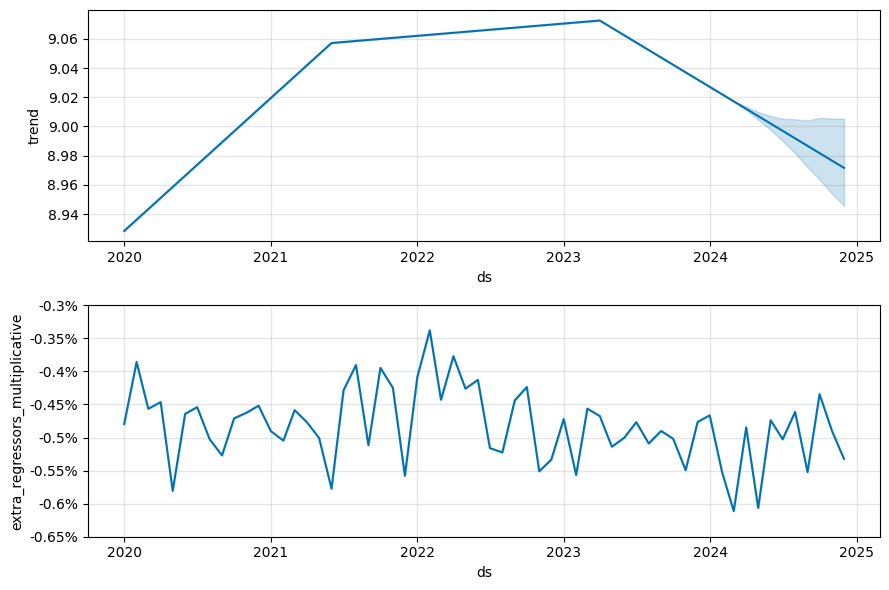

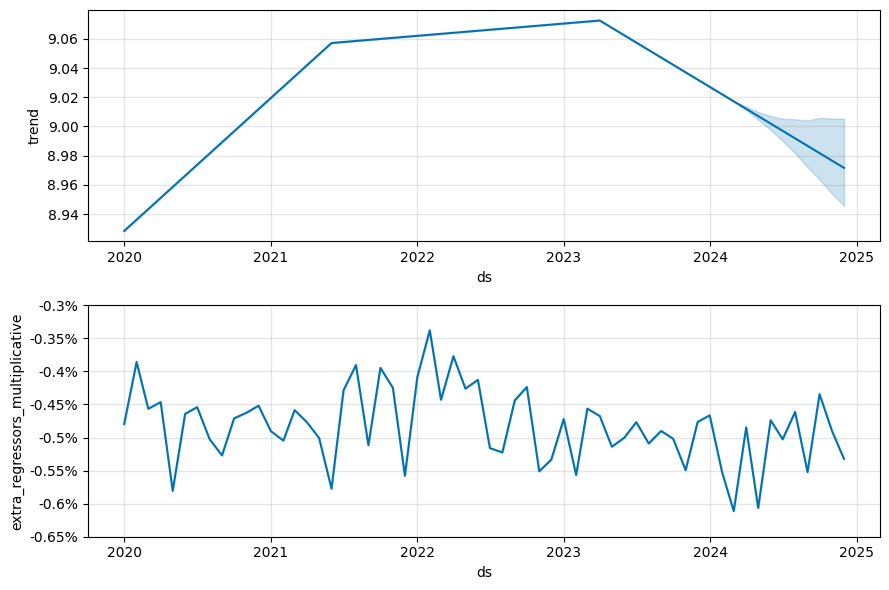

In [25]:
###################CLUSTER 3###################################
# 1. Imports et chargement -------------------------------------------------
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot_components
import matplotlib.pyplot as plt
import numpy as np

cluster = 3
df_cluster = train_periodique_q12[train_periodique_q12["cluster"] == cluster].copy().reset_index()
exog_cols = ["y_geo", "dpeL", "taux_rendement_n7",  "loyer_m2_median_n7", "taux", "nb_pieces", "IPS_primaire"]

# Renommage + sélection
df_train_prophet = df_cluster.rename(columns={'date': 'ds', 'prix_m2_vente': 'y'})[['ds', 'y'] + exog_cols]

# 2. Ajustement du modèle --------------------------------------------------
changepoints = ['2021-06-01', '2022-07-01', '2023-04-01']
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,        # Sensibilité aux ruptures
    changepoints=changepoints,
    seasonality_mode='multiplicative',  # Meilleur pour les données log-transfo
    seasonality_prior_scale=10.0,
    interval_width=0.8
)

# Ajouter les régresseurs
for reg in exog_cols:
    m.add_regressor(reg)

# Entraînement
m.fit(df_train_prophet)

# 3. Prévision -------------------------------------------------------------
future = m.make_future_dataframe(periods=12, freq='M')

# Générer des valeurs futures exogènes avec une légère variation
for col in exog_cols:
    last_val = df_train_prophet[col].iloc[-1]
    noise = np.random.normal(0, 0.01, size=len(future))
    future[col] = last_val + noise

forecast = m.predict(future)

# Revenir à l’échelle réelle (log inverse)
forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.exp(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
m.history['y'] = np.exp(m.history['y'])

# 4. Visualisation de la prévision -----------------------------------------
fig1 = m.plot(forecast)
plt.title(f'Prévision du prix m² (en €) – Cluster {cluster}: {dico[str(cluster)]}')
plt.ylabel("Prix €/m²")
plt.tight_layout()
plt.show()

# 5. Tendance (exp(trend)) -------------------------------------------------
df_trend = forecast[['ds', 'trend']].copy()
df_trend['trend_euros'] = np.exp(df_trend['trend'])

plt.figure(figsize=(10, 4))
plt.plot(df_trend['ds'], df_trend['trend_euros'], label='Tendance (€/m²)')
plt.xlabel("Date")
plt.ylabel("Prix €/m²")
plt.title("Tendance du prix au m² (exp(trend Prophet))")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# 6. Cross-validation ------------------------------------------------------
df_cv = cross_validation(
    model=m,
    initial='730 days',
    period='180 days',
    horizon='365 days',
    parallel="processes"
)

df_p = performance_metrics(df_cv)

fig2 = plot_cross_validation_metric(df_cv, metric='mape')
plt.title("MAPE selon l'horizon de prévision")
plt.ylabel("MAPE (%)")
plt.xlabel("Horizon")
plt.tight_layout()
plt.show()

print(df_p[['horizon', 'mape', 'mae', 'rmse']].head())
print(m.extra_regressors)

# 7. Composants saisonniers, tendance, changepoints
plot_components(m, forecast)



Conclusions à jour


#  Analyse Globale – Modélisation SARIMAX vs Prophet par cluster
| Cluster   | MAE (€/m²) | MAPE (%) | Niveau de Prix | Volatilité |
|-----------|------------|----------|----------------|------------|
| Cluster 0 | 30.11      | 1.03     | Moyen-bas      | Faible     |
| Cluster 1 | 72.20      | 3.10     | Moyen          | Moyenne    |
| Cluster 2 | 64.50      | 3.00     | Moyen-haut     | Faible     |
| Cluster 3 | 130.63     | 1.64     | Élevé          | Élevée     |


##  Surapprentissage & Généralisation (Mise à jour IQR)

| Cluster | Zone                           | Seuil IQR haut (€/m²) | MSE Train | MSE Test | MAE Test (€) | Surapprentissage | Dynamique test bien suivie ?             |
|--------:|--------------------------------|-----------------------:|----------:|---------:|--------------:|------------------:|-------------------------------------------|
| **0**   |Banlieue parisienne, zone mixte  | 4 574.5                | 2 163.9   | 1 835.3  | **30.1**      | :x: Non             | :white_check_mark: Oui (légère sous-estimation)            |
| **1**   | Centre urbain établi            | 2 796.7                | 6 406.7   | 7 167.4  | **72.2**      | :warning: Modéré          | :x: Sous-estimation persistante             |
| **2**   | Zone rurale villes stagnantes   | 2 420.0                | 1 090.3   | 5 191.9  | **64.5**      | :warning: Modéré          | :x: Prophet : meilleure forme, test mieux   |
| **3**   | Ville spéculative / luxe        | 9 289.2                | 12 328.9  | 22 610.4 | **130.6**     | :warning: Modéré          | :warning: Partiel (bruit test non anticipé)       |

---

##  Analyse détaillée par cluster

###  Cluster 0 – Banlieue parisienne, zone mixte(not. zones frontalières)

- SARIMAX(1,2,1) très stable.
- Erreurs faibles, pas de bruit, résidus propres.
- Pas besoin de Prophet ici.

**Conclusion** :
Modèle parfait pour un marché stable et prévisible.

---

### Cluster 1 – Centre urbain établi, zone résidentielle

- MSE test > train, sous-estimation persistante.
- SARIMAX ne capture pas les dynamiques locales.

**Suggestions** :
- Ajouter exogènes socio-économiques locales.
- Repenser le clustering (mobilité, revenus, etc.): le cluster est assez dispersé géographiquement
- Travailler avec les équipes métiers pour mieux cerner la spécificité du cluster et le resegmenter (si besoin) en fonction
---

### Cluster 2 –   Zone rurale 

- **SARIMAX échoue à prédire l’évolution récente.**
- **Prophet capte mieux les ruptures mais reste trop "lisse".**
- Bonne base de tendance, mais pas assez de variabilité.

**Suggestions** :
- **Intégration des changepoints manuels (ex. août 2022).**
- Ajouter saisonnalité

---

###  Cluster 3 – Ville spéculative, luxe

- SARIMAX modélise bien les exogènes mais lisse trop les pics.
- **Prophet suit beaucoup mieux la forme réelle (hausse → baisse).**
- Volatilité captée partiellement avec Prophet + changepoints.

**Suggestions** :
- Utiliser Prophet avec `changepoints` pour ajuster les retournements.
- Éventuellement combiner Prophet (tendance) + modèle ML (résidus).

---

## :scales: Synthèse comparative SARIMAX / Prophet

| Cluster                    | SARIMAX – Forces            | SARIMAX – Limites                | Prophet – Apport principal                          |
|---------------------------:|-----------------------------|----------------------------------|-----------------------------------------------------|
| **Banlieu et zone mixte**  | Très bon suivi, erreurs faibles | Aucun besoin d’amélioration      | :x: Prophet inutile – marché parfaitement modélisé    |
| **Centre urbain établi**   | Base solide, stabilité       | Tendance mal captée              | :soon: À tester                                          |
| **Zone rurale**            | Bon suivi historique         | Mauvaise prévision test          | :white_check_mark: Capte mieux la forme, changepoints efficaces     |
| **Zone tendue**            | Bonne modélisation structurelle | Trop lissé                      | :white_check_mark: Suivi plus précis des retournements et des pics  |

---